# Enoncé
## Contexte
**Mon rôle** : data scientist pour la ville de Seattle

**Commanditaire** : ville de Seattle

**Activité de l'entreprise :** établissement public à caractère administratif gérant Seattle

**Projet :** objectif de ville neutre en émissions de carbone en 2050

**Type de Mission :** prédiction de données

## Attendus
**But de la mission :** tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées &  évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe

**Détails de la mission :** Les données de consommation sont à télécharger à cette adresse : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir. Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction).

**Etapes demandées :**
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :
- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

/!\ Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :
- L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 
- Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).
- Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

**Script concerné :** 
- **Un notebook de l'analyse exploratoire mis au propre et annoté.**
- Un notebook des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.

# Importations
## Librairies et paramétrages

In [1]:
'''import re
import pip
listLib = !pip list --outdated --format freeze
listLib = list(listLib)
listLib = [re.sub('(\=)+(.)+$', '', i) for i in listLib]
pip.main(['install'] + listLib + ['--upgrade'] + ['--user'])
!pip list --outdated'''

"import re\nimport pip\nlistLib = !pip list --outdated --format freeze\nlistLib = list(listLib)\nlistLib = [re.sub('(\\=)+(.)+$', '', i) for i in listLib]\npip.main(['install'] + listLib + ['--upgrade'] + ['--user'])\n!pip list --outdated"

In [2]:
# Gestion des données
import pandas as pd
import numpy as np

import re

from sklearn import preprocessing, decomposition
from functions import *
from datetime import date 

# test d'indépendance
from scipy.stats import chi2_contingency

# Gestion des graphiques
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


from collections import Counter

# Format des résultats affichés
pd.set_option('display.max_columns', None) # display.max_columns : contrôle le nombre de colonnes à imprimer (int ou None pour imprimer toutes les colonnes)
pd.set_option('max_colwidth', None) # Vous pouvez augmenter la largeur en passant un int (ou mettre au max en passant None)
pd.set_option("display.max_rows", 1000) # Pour modifier le nombre de lignes, vous devez modifier l' option max_rows 
pd.options.display.float_format = '{:.2f}'.format # enlève le format d'affichage : nombre scientifique

# Pour afficher les graphiques dans la continuité du code, et non pas dans une fenêtre à part:
%matplotlib inline

## Jeu de données

In [3]:
df_2015 = pd.read_csv("E:/Formations/6. Diplôme Data Scientist/Projet/Projet-4/2015_Building_Energy_Benchmarking.csv"
                 , sep=",", decimal = '.', encoding="utf-8") 
df_2016 = pd.read_csv("E:/Formations/6. Diplôme Data Scientist/Projet/Projet-4/2016_Building_Energy_Benchmarking.csv"
                 , sep=",", decimal = '.', encoding="utf-8")

#  Vérifications des données
## Comparaison de structure

In [4]:
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df_2015.shape[0],df_2015.shape[1]).replace(',',' '))
df_2015.sample(10)

Il y a 3 340 lignes dans le df et 42 colonnes.


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier
1843,22934,2015,Multifamily LR (1-4),Low-Rise Multifamily,CHARDONNAY APARTMENTS,2925049066,"203 BELLEVUE AVE E\nSEATTLE, WA 98102\n(47.61966702, -122.3269598)",3,EAST,1906,1,3.00,24560,0,24560,Multifamily Housing,Multifamily Housing,20235.00,NaN,NaN,NaN,NaN,NaN,22.00,39.50,45.40,88.90,105.80,798970.00,919086.00,0.00,134648.00,459436.00,3396.00,339553.00,0.00,21.24,0.78,No,NaN,Compliant,NaN
783,19757,2015,Multifamily LR (1-4),Low-Rise Multifamily,OREGON APARTMENTS,654000280,"2301 1ST AVE\nSEATTLE, WA 98121\n(47.6133674, -122.34702308)",7,DOWNTOWN,1902,1,4.00,56776,0,56776,Multifamily Housing,Multifamily Housing,50841.00,NaN,NaN,NaN,NaN,NaN,98.00,35.10,39.30,65.50,75.20,1784233.00,1997417.00,0.00,204092.00,696392.00,10879.00,1087870.00,0.00,62.63,1.05,No,NaN,Compliant,NaN
1490,22438,2015,NonResidential,Worship Facility,QUEST CHURCH,2768302590,"1401 NW LEARY WAY\nSEATTLE, WA 98107\n(47.66327432, -122.3744499)",6,BALLARD,1975,1,1.00,84595,0,84595,Worship Facility,Worship Facility,40445.00,NaN,NaN,NaN,NaN,NaN,44.00,35.10,41.40,75.20,81.80,1417778.00,1672928.00,0.00,217484.00,742085.00,6757.00,675724.00,0.00,41.06,0.45,No,NaN,Compliant,NaN
20,268,2015,NonResidential,Hospital,SWEDISH MEDICAL CENTER CHERRY HILL CAMPUS,7942600331,"500 17TH AVE\nSEATTLE, WA 98122\n(47.60710663, -122.3107827)",3,CENTRAL,1990,1,5.00,597519,0,597519,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),601615.00,Parking,48607.00,NaN,NaN,NaN,45.00,228.80,236.90,434.80,434.90,137635696.00,142494256.00,0.00,16416700.00,56016106.00,816219.00,81621919.00,0.00,4725.43,7.51,No,NaN,Compliant,NaN
3118,50019,2015,Multifamily MR (5-9),Mid-Rise Multifamily,306 QUEENE ANNE APTS,1989201221,"306 QUEEN ANNE AVE N\nSEATTLE, WA 98109\n(47.62130626, -122.3562214)",7,MAGNOLIA / QUEEN ANNE,2014,1,8.00,31990,0,31990,Multifamily Housing,Multifamily Housing,31990.00,NaN,NaN,NaN,NaN,NaN,99.00,30.60,30.60,70.40,70.40,980073.00,980073.00,0.00,171717.00,585923.00,3942.00,394175.00,0.00,25.02,0.70,No,NaN,Compliant,NaN
1570,21298,2015,Multifamily MR (5-9),Mid-Rise Multifamily,FIRST AND REPUBLICAN APTS,1989201170,"422 1ST AVE W\nSEATTLE, WA 98119\n(47.6228489, -122.3576637)",7,MAGNOLIA / QUEEN ANNE,1999,1,6.00,65712,21145,44567,"Multifamily Housing, Parking",Multifamily Housing,44567.00,Parking,21145.00,NaN,NaN,NaN,97.00,31.00,33.90,83.40,88.80,1381407.00,1508612.00,0.00,317634.00,1083814.00,2976.00,297638.00,0.00,23.36,0.28,No,NaN,Compliant,NaN
2025,24515,2015,Multifamily LR (1-4),Low-Rise Multifamily,HARRISON COURT CONDOMINIUM,3130900000,"130 NE 95TH ST\nSEATTLE, WA 98115\n(47.69804588, -122.326985)",5,NORTH,1990,1,4.00,54304,0,54304,"Multifamily Housing, Parking",Multifamily Housing,68138.00,Parking,21120.00,NaN,NaN,NaN,94.00,22.90,25.00,72.00,78.30,1562708.00,1700173.00,0.00,458004.00,1562773.00,0.00,0.00,0.00,10.89,0.08,No,NaN,Compliant,NaN
531,613,2015,NonResidential,Small- and Mid-Sized Office,GRAND CENTRAL BUILDING,5247800390,"216 1ST AVE S\nSEATTLE, WA 98104\n(47.60046292, -122.3337871)",7,DOWNTOWN,1900,1,4.00,84750,0,84750,"Office, Retail Store",Office,41609.00,Retail Store,28734.00,NaN,NaN,NaN,95.00,34.00,36.10,97.00,99.10,2392466.00,2536280.00,0.0

In [5]:
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df_2016.shape[0],df_2016.shape[1]).replace(',',' '))
df_2016.sample(10)

Il y a 3 376 lignes dans le df et 46 colonnes.


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3016,27885,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Lee Plaza,4746 11th Ave NE,Seattle,WA,98105.00,6746701020,4,NORTHEAST,47.66,-122.32,1991,1.00,5,64227,0,64227,"Multifamily Housing, Office, Parking",Multifamily Housing,40152.00,Parking,16986.00,Office,7089.00,NaN,96.00,40.90,43.10,84.10,88.60,1930541.50,2034690.12,0.00,273166.31,932043.00,9984.98,998498.00,False,NaN,Compliant,NaN,59.53,0.93
2853,27213,2016,Multifamily LR (1-4),Low-Rise Multifamily,Lockshore Condominium,3200 W Commodore Way,Seattle,WA,98199.00,4395400000,7,MAGNOLIA / QUEEN ANNE,47.66,-122.40,1965,1.00,3,28944,0,28944,"Multifamily Housing, Swimming Pool",Multifamily Housing,24111.00,Swimming Pool,0.00,NaN,NaN,NaN,39.00,35.90,38.10,107.10,115.10,864751.81,917574.00,0.00,234862.20,801350.00,634.02,63402.00,False,NaN,Compliant,NaN,8.95,0.31
2033,24201,2016,Multifamily LR (1-4),Low-Rise Multifamily,Washington Irving,1305 E Howell St,Seattle,WA,98122.00,6003000930,3,EAST,47.62,-122.32,1923,1.00,4,30920,0,30920,"Multifamily Housing, Parking",Multifamily Housing,30920.00,Parking,7260.00,NaN,NaN,NaN,73.00,37.70,40.50,90.60,99.30,1166069.88,1251866.88,0.00,220969.50,753948.00,4121.22,412122.00,False,NaN,Compliant,NaN,27.14,0.88
1856,23609,2016,Multifamily LR (1-4),Low-Rise Multifamily,Del Mar Apt,14033 32nd ave ne,Seattle,WA,98125.00,7663700860,5,NORTH,47.73,-122.29,1981,1.00,4,43132,0,43132,Multifamily Housing,Multifamily Housing,43132.00,NaN,NaN,NaN,NaN,NaN,46.00,28.50,30.00,89.50,94.20,1228837.25,1293593.00,0.00,360151.59,1228837.00,0.00,0.00,False,NaN,Compliant,NaN,8.57,0.20
1111,20890,2016,NonResidential,K-12 School,ASB School,6220 32nd Ave. NE,Seattle,WA,98115.00,1868903240,4,NORTHEAST,47.67,-122.29,1986,1.00,1,23190,0,23190,K-12 School,K-12 School,23190.00,NaN,NaN,NaN,NaN,NaN,79.00,73.50,83.20,121.10,131.20,1705515.25,1929416.50,0.00,142531.09,486316.00,12191.99,1219199.00,False,NaN,Compliant,NaN,68.14,2.94
1276,21425,2016,NonResidential,Other,Pacific Science Center,200 Second Avenue North,Seattle,WA,98109.00,1985200140,7,MAGNOLIA / QUEEN ANNE,47.62,-122.35,1962,1.00,1,155795,0,155795,Other,Other,155795.00,NaN,NaN,NaN,NaN,NaN,NaN,113.40,121.00,317.60,330.80,17673018.00,18847708.00,0.00,4337207.50,14798552.00,28744.65,2874465.00,False,NaN,Compliant,NaN,255.83,1.64
2362,25407,2016,Multifamily MR (5-9),Mid-Rise Multifamily,"Market Court, a Condomium",2030 Western Ave,Seattle,WA,98121.00,5160450000,7,DOWNTOWN,47.61,-122.34,1989,1.00,7,87645,0,87645,"Multifamily Housing, Parking, Retail Store",Multifamily Housing,60501.00,Retail Store,11489.00,Parking,0.00,NaN,95.00,30.30,30.70,79.60,80.00,2184156.50,2206851.50,0.00,482449.09,1646116.00,5380.40,538040.00,False,NaN,Compliant,NaN,40.05,0.46
2275,25092,2016,Multifamily LR (1-4),Low-Rise Multifamily,Spencer House Apartments,10541 Stone Ave. N.,Seattle,WA,98133.00,6300000530,5,NORTHWEST,47.71,-122.34,1984,1.00,3,20980,0,20980,"Multifamily Housing, Parking",Multifamily Housing,16980.00,Parking,4000.00,NaN,NaN,NaN,96.00,23.30,24.20,73.10,75.90,395346.31,410519.91,0.00,115869.40,395346.00,0.00,0.00,False,NaN,Compliant,NaN,2.76,0.13
1672,23071,2016,NonResidential,Hospital,Main Hospital - All Wings,Facilities Management MS: B-120

Je peux déjà apercevoir des différences de structures entre les 2 jeu de données.

Après avoir affiché la structure générale des jeux de données, je vérifie la présence de doublons pour chaque fichier.

In [6]:
print('Il y a {} doublons dans le fichier de 2015.'.format(df_2015.duplicated(subset=['OSEBuildingID']).sum()))
print('Il y a {} doublons dans le fichier de 2016.'.format(df_2016.duplicated(subset=['OSEBuildingID']).sum()))

Il y a 0 doublons dans le fichier de 2015.
Il y a 0 doublons dans le fichier de 2016.


Tout va bien, aucun doublons dans les fichiers, je vais maintenant afficher les variables qui diffèrent entre les fichiers.

In [7]:
list_2015 = df_2015.columns.to_list()
list_2016 = df_2016.columns.to_list()
list_diff_2015 = [x for x in list_2015 if x not in list_2016]
list_diff_2016 = [x for x in list_2016 if x not in list_2015]
print("2015 not in 2016 :",list_diff_2015)
print("2016 not in 2015 :",list_diff_2016)
del list_2015, list_2016, list_diff_2015, list_diff_2016

2015 not in 2016 : ['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment']
2016 not in 2015 : ['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude', 'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


**A première vue, voici les transformations à opérer :**

Spilting : 
- 'Location' ==> 'Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude'

Rename :
- 'Comment' ==> 'Comments'
- 'GHGEmissions(MetricTonsCO2e)' ==> 'TotalGHGEmissions'
- 'GHGEmissionsIntensity(kgCO2e/ft2)' ==> 'GHGEmissionsIntensity'

**Il reste :**

Colonnes manquantes pour df_2016 :
- 'OtherFuelUse(kBtu)'

In [8]:
df_2015[['OtherFuelUse(kBtu)']].isna().mean()

OtherFuelUse(kBtu)   0.00
dtype: float64

Aucune valeur manquante dans la variable *OtherFuelUse(kBtu)*. Je vais donc la garder, créer cette colonne dans le fichier 2016 avec NA pour valeur.

Avant de passer à la transformation des fichiers de données, je vais continuer la vérification des données en comparant la plupart des variables des 2 fichiers entre elles, afin d'être sûr qu'il y ait les mêmes types de données.

## Comparaison des types de données

In [9]:
df_types_2015 = pd.DataFrame(df_2015.dtypes.sort_index(), columns = ['2015'])
df_types_2016 = pd.DataFrame(df_2016.dtypes.sort_index(), columns = ['2016'])
df_types = df_types_2015.merge(df_types_2016, how='outer', left_index=True, right_index=True)
del df_types_2016, df_types_2015
df_types

,2015,2016
Address,NaN,object
BuildingType,object,object
City,NaN,object
Comment,object,NaN
Comments,NaN,float64
ComplianceStatus,object,object
CouncilDistrictCode,int64,int64
DataYear,int64,int64
DefaultData,object,bool
ENERGYSTARScore,float64,float64


Avant de comparer les types des variables entre elles. Je peux déjà voir que :
- La variable *ZipCode* est en float dans le fichier 2016, où elle est présente uniquement. Je vais la transformer en category, puisqu'un code postal se rapproche plus d'une catégorie que d'une quantité. 
- Tout comme la variable *OSEBuildingID* qui est int, alors qu'elle représente l'identifiant du bâtiment. Je vais donc la transformer en objet.
- Les variables suffixé GFA sont des variables de superficie, certaines sont en integer, d'autres en float. Je vais vérifier si les variables float contiennent autre chose que des décimals à 0. Si ce n'est pas le cas, je les transformerais en integer.

De plus, on peut voir que  Comments (fichier 2016), DefaultData, et NumberofBuildings/NumberofFloors, n'ont pas les mêmes types de données. 
- La variable Comments (fichier 2016) est en float alors qu'elle devrait être en object, surement parce qu'elle est vide.
- Pour DefaultData, je vais voir les modalités des 2 fichiers.
- NumberofBuildings et NumberofFloors doivent logiquement être au format int, puisqu'il ne peut pas y avoir 1 batiment et demi par exemple. 

In [10]:
del df_types

In [11]:
print(df_2015['DefaultData'].value_counts())
print("---------------------------------")
print(df_2016['DefaultData'].value_counts())

No     2791
Yes     548
Name: DefaultData, dtype: int64
---------------------------------
False    3263
True      113
Name: DefaultData, dtype: int64


Pour DefaultData, je vais donc transformer la variable du fichier de 2015 en variable booléenne avec :
- *\"False"* pour les valeurs *\"No"* et 
- *\"True"* pour les valeurs *\"Yes"*. 

Enfin, la variable *Comment* (2015) est en object alors que la variable *Comments* (2016) est float. Cela est surement dû au fait que *Comments* (2016) est vide. Je vérifie...

In [12]:
df_2016['Comments'].isna().mean() *100

100.0

C'est exact, la variable *Comments* (2016) est en float, car elle est vide. Je vais tout de même la garder et je regarderai après jointure les variables que je garde ou non. Pour cette variable là, je vais juste modifier son type pour qu'elle soit de type object. 

# Nettoyage
## Faire coïncider les variables

Je vais commencer par m'occuper des différentes variables entre le fichier de 2015 et celui de 2016.

### Splitting

Pour cela, je vais d'abord splitter la variable *Location* de df_2015 en 6 variables distincts respectivement : 'Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude'.

In [13]:
df_split = df_2015['Location'].str.split(pat = "\n", expand = True)

# Je splitte le tout par '\n' 
df_split = df_split.rename(columns={0: 'Address', 1: 'City_State_ZipCode', 2: 'Latitude_Longitude'})

# Je splitte City_State_ZipCode en : City d'un côté et State_ZipCode de l'autre
df_split['City'] = df_split['City_State_ZipCode'].str.split(", ", n = 1, expand = True)[0]
df_split['State_ZipCode'] = df_split['City_State_ZipCode'].str.split(", ", n = 1, expand = True)[1]
df_split = df_split.drop(columns = ['City_State_ZipCode'])

# Je splitte State_ZipCode en : State d'un côté et ZipCode de l'autre
df_split['State'] = df_split['State_ZipCode'].str.split(" ", n = 1, expand = True)[0]
df_split['ZipCode'] = df_split['State_ZipCode'].str.split(" ", n = 1, expand = True)[1]
df_split = df_split.drop(columns = ['State_ZipCode'])

# Je splitte Latitude_Longitude en : Latitude d'un côté et Longitude de l'autre
df_split['Latitude'] = df_split['Latitude_Longitude'].str.split(",", n = 1, expand = True)[0]
df_split['Latitude'] = df_split['Latitude'].str.replace('(','', regex = False)
df_split['Longitude'] = df_split['Latitude_Longitude'].str.split(",", n = 1, expand = True)[1]
df_split['Longitude'] = df_split['Longitude'].str.replace(')','', regex = False)
df_split = df_split.drop(columns = ['Latitude_Longitude'])

# J'arrondi Latitude et Longitude à 2 décimales
df_split['Latitude'] = df_split['Latitude'].astype(float)
df_split['Longitude'] = df_split['Longitude'].astype(float)


df_split.head()

,Address,City,State,ZipCode,Latitude,Longitude
0,411 W REPUBLICAN ST,SEATTLE,WA,98119,47.62,-122.36
1,6100 CORSON AVE S,SEATTLE,WA,98108,47.55,-122.32
2,201 YESLER WAY,SEATTLE,WA,98104,47.60,-122.33
3,800 FAIRVIEW AVE N,SEATTLE,WA,98109,47.63,-122.33
4,3670 E MARGINAL WAY S,SEATTLE,WA,98134,47.57,-122.34


In [14]:
df_split.isna().sum()

Address      0
City         0
State        0
ZipCode      0
Latitude     0
Longitude    0
dtype: int64

In [15]:
# j'affecte les nouvelles variables au jeu de données
df_2015 = df_2015.merge(df_split, left_index = True, right_index = True, how = 'left')

# je supprime la colonne source
df_2015 = df_2015.drop(columns = 'Location')

del df_split
df_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,Address,City,State,ZipCode,Latitude,Longitude
0,21548,2015,Multifamily LR (1-4),Low-Rise Multifamily,PUGET VISTA APTS,1992200030,7,MAGNOLIA / QUEEN ANNE,1967,1,4.00,40086,6133,33953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not Compliant,NaN,411 W REPUBLICAN ST,SEATTLE,WA,98119,47.62,-122.36
1,26379,2015,NonResidential,Hotel,GEORGETOWN INN,6920700025,2,GREATER DUWAMISH,1992,1,3.00,22452,0,22452,Hotel,Hotel,22452.00,NaN,NaN,NaN,NaN,NaN,78.00,60.30,61.50,118.20,122.00,1354219.00,1381137.00,0.00,172881.00,589893.00,7644.00,764350.00,0.00,44.71,1.88,No,NaN,Compliant,NaN,6100 CORSON AVE S,SEATTLE,WA,98108,47.55,-122.32
2,26713,2015,Multifamily HR (10+),High-Rise Multifamily,QUINTESSA APTS,5247800955,7,DOWNTOWN,2007,1,13.00,90959,0,90959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.00,48.00,52.20,115.40,126.20,4361755.00,4748161.00,0.00,829363.00,2829904.00,15320.00,1531968.00,0.00,101.09,0.98,No,NaN,Compliant,NaN,201 YESLER WAY,SEATTLE,WA,98104,47.60,-122.33
3,102,2015,NonResidential,Hotel,MARRIOTT RESIDENCE INN,1984200065,3,LAKE UNION,1990,1,7.00,282863,44766,238097,"Hotel, Parking",Hotel,235788.00,Parking,51537.00,NaN,NaN,NaN,40.00,79.90,85.30,178.10,186.60,18829136.00,20123722.00,0.00,3117920.00,10638785.00,81908.00,8190794.00,0.00,509.18,1.64,No,NaN,Compliant,NaN,800 FAIRVIEW AVE N,SEATTLE,WA,98109,47.63,-122.33
4,503,2015,NonResidential,Supermarket/Grocery Store,RESTAURANT DEPOT,1824049003,2,GREATER DUWAMISH,2008,1,1.00,63225,0,63225,Supermarket/Grocery Store,Supermarket/Grocery Store,63225.00,NaN,NaN,NaN,NaN,NaN,100.00,104.70,104.70,328.80,328.80,6619941.00,6619941.00,0.00,1940194.00,6620217.00,0.00,0.00,0.00,46.15,0.28,No,NaN,Compliant,NaN,3670 E MARGINAL WAY S,SEATTLE,WA,98134,47.57,-122.34


La première étape de transformation des variables est finalisée.

Je vais maintenant passer à la deuxième : renommer les noms des variables.

### Rename

Pour cela, pour les variables du fichier 2015, je vais renommer : 
- 'Comment' en 'Comments'
- 'GHGEmissions(MetricTonsCO2e)' en 'TotalGHGEmissions'
- 'GHGEmissionsIntensity(kgCO2e/ft2)' en 'GHGEmissionsIntensity'

In [16]:
df_2015 = df_2015.rename(columns = {'Comment' : 'Comments'
                                    , 'GHGEmissions(MetricTonsCO2e)' : 'TotalGHGEmissions'
                                    , 'GHGEmissionsIntensity(kgCO2e/ft2)' : 'GHGEmissionsIntensity'
                                   })
df_2015.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'OtherFuelUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 

Voilà, maintenant dernière étape : création de variable.

### Create

Pour cela, je vais créer une nouvelle variable dans le fichier 2016 nommé (comme pour 2015) *OtherFuelUse(kBtu)* et lui affecter NA pour toutes les lignes.

In [17]:
df_2016['OtherFuelUse(kBtu)'] = np.nan
df_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,OtherFuelUse(kBtu)
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.00,0659000030,7,DOWNTOWN,47.61,-122.34,1927,1.00,12,88434,0,88434,Hotel,Hotel,88434.00,NaN,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,False,NaN,Compliant,NaN,249.98,2.83,NaN
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.00,0659000220,7,DOWNTOWN,47.61,-122.33,1996,1.00,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,NaN,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,False,NaN,Compliant,NaN,295.86,2.86,NaN
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.00,0659000475,7,DOWNTOWN,47.61,-122.34,1969,1.00,41,956110,196718,759392,Hotel,Hotel,756493.00,NaN,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,False,NaN,Compliant,NaN,2089.28,2.19,NaN
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.00,0659000640,7,DOWNTOWN,47.61,-122.34,1926,1.00,10,61320,0,61320,Hotel,Hotel,61320.00,NaN,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,False,NaN,Compliant,NaN,286.43,4.67,NaN
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.00,0659000970,7,DOWNTOWN,47.61,-122.34,1980,1.00,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,NaN,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,False,NaN,Compliant,NaN,505.01,2.88,NaN


Maintenant que les 2 fichiers ont la même structure en terme de variable, je vais transformer les types de certaines variables, pour faire coïncider les valeurs.

## Transformation des types des variables
### Object / Category

Je vais transformer la variable *Comments* (2016) en object.

In [18]:
df_2016['Comments'] = df_2016['Comments'].astype(str)
print('2016 :',df_2016['Comments'].dtypes)

2016 : object


Parfait, je vais ensuite transformer les variables *NumberofBuildings* (2016) et *NumberofFloors* (2015) en integer.

### Integer

In [19]:
df_2016['NumberofBuildings'] = df_2016['NumberofBuildings'].astype('Int64')
df_2015['NumberofFloors'] = df_2015['NumberofFloors'].astype('Int64')
print('2015 - NumberofBuildings :', df_2015['NumberofBuildings'].dtypes)
print('2016 - NumberofBuildings :', df_2016['NumberofBuildings'].dtypes)
print('2015 - NumberofFloors :', df_2015['NumberofFloors'].dtypes)
print('2016 - NumberofFloors :', df_2016['NumberofFloors'].dtypes)

2015 - NumberofBuildings : int64
2016 - NumberofBuildings : Int64
2015 - NumberofFloors : Int64
2016 - NumberofFloors : int64


In [20]:
df_2015['ZipCode'] = df_2015['ZipCode'].astype(str).astype(int)
df_2016['ZipCode'] = df_2016['ZipCode'].astype('Int64')
print('2015 - ZipCode :', df_2015['ZipCode'].dtypes)
print('2016 - ZipCode :', df_2016['ZipCode'].dtypes)

2015 - ZipCode : int32
2016 - ZipCode : Int64


In [21]:
listVarModif = list(df_2015.select_dtypes(['float']).columns)
listVarModif.append(list(df_2016.select_dtypes(['float']).columns))
listVarModif = [x for x in listVarModif if 'GFA' in x]
print('Vérification de la (des) colonne(s) :', listVarModif)

for col in listVarModif:
    nbDec2015 = len(df_2015[(~df_2015[col].astype(str).str.contains('.0'))&(~df_2015[col].isna())])
    nbDec2016 = len(df_2016[(~df_2016[col].astype(str).str.contains('.0'))&(~df_2016[col].isna())])
    if nbDec2015 == 0 & nbDec2016 == 0:
        print('Modification de la colonne :', col)
        df_2015[col] = np.floor(pd.to_numeric(df_2015[col], errors='coerce')).astype('Int64')
        df_2016[col] = np.floor(pd.to_numeric(df_2016[col], errors='coerce')).astype('Int64')
    del nbDec2015, nbDec2016

print(df_2015[listVarModif].dtypes)
print(df_2016[listVarModif].dtypes)
del listVarModif

Vérification de la (des) colonne(s) : ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
Modification de la colonne : LargestPropertyUseTypeGFA
Modification de la colonne : SecondLargestPropertyUseTypeGFA
Modification de la colonne : ThirdLargestPropertyUseTypeGFA
LargestPropertyUseTypeGFA          Int64
SecondLargestPropertyUseTypeGFA    Int64
ThirdLargestPropertyUseTypeGFA     Int64
dtype: object
LargestPropertyUseTypeGFA          Int64
SecondLargestPropertyUseTypeGFA    Int64
ThirdLargestPropertyUseTypeGFA     Int64
dtype: object


Enfin, je vais transformer *DefaultData* (2015) en variable booléenne (True/False).

### Booléen

In [22]:
df_2015.loc[df_2015['DefaultData'] == 'No', 'DefaultData'] = False
df_2015.loc[df_2015['DefaultData'] == 'Yes', 'DefaultData'] = True
df_2015['DefaultData'] = df_2015['DefaultData'].astype(bool)
print('2015 :', df_2015['DefaultData'].dtypes)
print('2016 :', df_2016['DefaultData'].dtypes)

2015 : bool
2016 : bool


In [23]:
df_types_2015 = pd.DataFrame(df_2015.dtypes.sort_index(), columns = ['2015'])
df_types_2016 = pd.DataFrame(df_2016.dtypes.sort_index(), columns = ['2016'])
df_types = df_types_2015.merge(df_types_2016, how='outer', left_index=True, right_index=True)
del df_types_2016, df_types_2015
df_types

,2015,2016
Address,object,object
BuildingType,object,object
City,object,object
Comments,object,object
ComplianceStatus,object,object
CouncilDistrictCode,int64,int64
DataYear,int64,int64
DefaultData,bool,bool
ENERGYSTARScore,float64,float64
Electricity(kBtu),float64,float64


In [24]:
del df_types

## Merge

Maintenant que les fichiers sont identiques, je vais pouvoir les réunir en un seul et même jeu de données.

In [25]:
df = pd.concat([df_2015,df_2016], ignore_index=True)
df = df.sort_values(['OSEBuildingID','DataYear'])
del df_2015, df_2016
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))
print('Il y a {:,} bâtiments dans le jeu de données.'.format(df['OSEBuildingID'].nunique()).replace(',',' '))
df.head()

Il y a 6 716 lignes dans le df et 47 colonnes.
Il y a 3 432 bâtiments dans le jeu de données.


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,Address,City,State,ZipCode,Latitude,Longitude
241,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,12,88434,0,88434,Hotel,Hotel,88434,NaN,<NA>,NaN,<NA>,NaN,65.00,78.90,80.30,173.50,175.10,6981428.00,7097539.00,2023032.00,1080307.00,3686160.00,12724.00,1272388.00,0.00,249.43,2.64,False,NaN,Compliant,NaN,405 OLIVE WAY,SEATTLE,WA,98101,47.61,-122.34
3340,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1,12,88434,0,88434,Hotel,Hotel,88434,NaN,<NA>,NaN,<NA>,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,NaN,249.98,2.83,False,nan,Compliant,NaN,405 Olive way,Seattle,WA,98101,47.61,-122.34
361,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880,Parking,15064,Restaurant,4622,NaN,51.00,94.40,99.00,191.30,195.20,8354235.00,8765788.00,0.00,1144563.00,3905411.00,44490.00,4448985.00,0.00,263.51,2.38,False,NaN,Compliant,NaN,724 PINE ST,SEATTLE,WA,98101,47.61,-122.33
3341,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880,Parking,15064,Restaurant,4622,NaN,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,NaN,295.86,2.86,False,nan,Compliant,NaN,724 Pine street,Seattle,WA,98101,47.61,-122.33
509,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1,41,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243,Parking,100000,Swimming Pool,0,NaN,18.00,96.60,99.70,242.70,246.50,73130656.00,75506272.00,19660404.00,14583930.00,49762435.00,37099.00,3709900.00,0.00,2061.48,1.92,True,NaN,Compliant,NaN,1900 5TH AVE,SEATTLE,WA,98101,47.61,-122.34


In [26]:
df.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
YearBuilt                            int64
NumberofBuildings                    Int64
NumberofFloors                       Int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA            Int64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA      Int64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA       Int64
YearsENERGYSTARCertified            object
ENERGYSTARScore                    float64
SiteEUI(kBt

Tout à l'air correcte, je m'occuperais de modifier certains types de variables avec avoir filtrer le jeu de données.

In [27]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,Address,City,State,ZipCode,Latitude,Longitude
241,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,12,88434,0,88434,Hotel,Hotel,88434,NaN,<NA>,NaN,<NA>,NaN,65.00,78.90,80.30,173.50,175.10,6981428.00,7097539.00,2023032.00,1080307.00,3686160.00,12724.00,1272388.00,0.00,249.43,2.64,False,NaN,Compliant,NaN,405 OLIVE WAY,SEATTLE,WA,98101,47.61,-122.34
3340,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1,12,88434,0,88434,Hotel,Hotel,88434,NaN,<NA>,NaN,<NA>,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,NaN,249.98,2.83,False,nan,Compliant,NaN,405 Olive way,Seattle,WA,98101,47.61,-122.34
361,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880,Parking,15064,Restaurant,4622,NaN,51.00,94.40,99.00,191.30,195.20,8354235.00,8765788.00,0.00,1144563.00,3905411.00,44490.00,4448985.00,0.00,263.51,2.38,False,NaN,Compliant,NaN,724 PINE ST,SEATTLE,WA,98101,47.61,-122.33
3341,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880,Parking,15064,Restaurant,4622,NaN,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,NaN,295.86,2.86,False,nan,Compliant,NaN,724 Pine street,Seattle,WA,98101,47.61,-122.33
509,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1,41,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243,Parking,100000,Swimming Pool,0,NaN,18.00,96.60,99.70,242.70,246.50,73130656.00,75506272.00,19660404.00,14583930.00,49762435.00,37099.00,3709900.00,0.00,2061.48,1.92,True,NaN,Compliant,NaN,1900 5TH AVE,SEATTLE,WA,98101,47.61,-122.34


Je peux voir avec la vue générale que la variable *Comments* comporte des valeurs 'nan' qui ne seront pas reconnues comme des valeurs manquantes. Avant d'afficher les valeurs manquantes, je devrais modifier cette variable.

## Filtrage des colonnes

In [28]:
df.loc[df['Comments'] == 'NAN','Comments'] = np.nan

In [29]:
df.isna().sum().sort_values(ascending = False)

Outlier                            6600
YearsENERGYSTARCertified           6487
ThirdLargestPropertyUseTypeGFA     5560
ThirdLargestPropertyUseType        5560
SecondLargestPropertyUseType       3478
SecondLargestPropertyUseTypeGFA    3478
OtherFuelUse(kBtu)                 3386
Comments                           3327
ENERGYSTARScore                    1623
LargestPropertyUseType              156
LargestPropertyUseTypeGFA           156
ListOfAllPropertyUseTypes           136
GHGEmissionsIntensity                19
SourceEUIWN(kBtu/sf)                 19
SourceEUI(kBtu/sf)                   19
NaturalGas(kBtu)                     19
NaturalGas(therms)                   19
TotalGHGEmissions                    19
SteamUse(kBtu)                       19
Electricity(kBtu)                    19
Electricity(kWh)                     19
SiteEUI(kBtu/sf)                     17
SiteEUIWN(kBtu/sf)                   16
SiteEnergyUseWN(kBtu)                16
ZipCode                              16


Je vais commencer par supprimer les variables les moins remplies : 
- *YearsENERGYSTARCertified*, 
- *ThirdLargestPropertyUseTypeGFA*, 
- *ThirdLargestPropertyUseType*, 
- *SecondLargestPropertyUseType* et 
- *SecondLargestPropertyUseTypeGFA*. 

Les variables *Outlier* et *ComplianceStatus* seront supprimées après utilisation.

*ENERGYSTARScore* étant utile pour mon analyse, je décide de la garder. 

Les variables de relevés de consommations, autre que les variables à prédire, ne sont ici pas importante. En effet, les prévisions doivent se passer de tout relevés de consommations. Je vais donc toutes les supprimer.

De plus, les données concernent tous les bâtiments de Seattle uniquement, il n'est donc pas intéressant de garder la ville, ainsi que l'état concernant l'adresse du bâtiment puisqu'elle sera toujours SEATTLE, WA.

Enfin, des variables sont suffixées GFA : Elles représente la surface au sol (Ground Floor Area). Cela peut être intéressant, je vais les garder pour la suite des analyses.

In [30]:
listVarDelete = ['Comments'
                , 'YearsENERGYSTARCertified'
                , 'ThirdLargestPropertyUseTypeGFA'
                , 'ThirdLargestPropertyUseType'
                , 'SecondLargestPropertyUseTypeGFA'
                , 'SecondLargestPropertyUseType'
                , 'NaturalGas(therms)'
                , 'Electricity(kWh)'
                , 'City'
                , 'State'
                , 'DefaultData'
                , 'GHGEmissionsIntensity']
df = df.drop(columns = listVarDelete)
del listVarDelete
listVarWN = df.columns
listVarWN = [x for x in listVarWN if 'WN' in x]
df = df.drop(columns = listVarWN)
del listVarWN
listVarConso = df.columns
listVarConso = [x for x in listVarConso if ('kBtu' in x) & (x != 'SiteEnergyUse(kBtu)')]
df = df.drop(columns = listVarConso)
del listVarConso
df.isna().sum().sort_values(ascending = False)

Outlier                          6600
ENERGYSTARScore                  1623
LargestPropertyUseType            156
LargestPropertyUseTypeGFA         156
ListOfAllPropertyUseTypes         136
TotalGHGEmissions                  19
ZipCode                            16
SiteEnergyUse(kBtu)                15
NumberofBuildings                   8
NumberofFloors                      8
TaxParcelIdentificationNumber       2
OSEBuildingID                       0
Latitude                            0
Address                             0
ComplianceStatus                    0
PropertyGFABuilding(s)              0
DataYear                            0
PropertyGFAParking                  0
PropertyGFATotal                    0
YearBuilt                           0
Neighborhood                        0
CouncilDistrictCode                 0
PropertyName                        0
PrimaryPropertyType                 0
BuildingType                        0
Longitude                           0
dtype: int64

Pour compléter, je vais supprimer les parties entre parenthèse des noms des colonnes.

In [31]:
listColPar = df.columns
listColPar = [x for x in listColPar if ('(' in x) | (')' in x)]
for col in listColPar:
    nouveauNom = re.sub('(\(.*\))', '', col)
    dictNom = {col : nouveauNom}
    df = df.rename(columns = dictNom)
del listColPar, nouveauNom, dictNom

Je vais continuer mon nettoyage en filtrant maintenant sur les lignes.

## Filtrage des lignes
### Suppression des propriétés dont on ne connait pas les variables à prédire

Tout d'abord, dans le cadre de nos modélisations, les variables à prédire sont la consommation d'énergie du bâtiment (*SiteEnergyUse*) et ses émissions de CO2 (*TotalGHGEmissions*). Certaines lignes comportent des valeurs manquantes sur ces variables, nous allons donc les supprimer :

In [32]:
indexASup = df.loc[(df['SiteEnergyUse'].isna())|(df['TotalGHGEmissions'].isna())].index.tolist()
print("Il y a {:,} lignes à supprimer.".format(len(indexASup)).replace(',',' '))
df = df.drop(indexASup)
del indexASup
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))

Il y a 19 lignes à supprimer.
Il y a 6 697 lignes dans le df et 26 colonnes.


### Suppression des propriétés qui sont résidentielles
Ensuite, comme indiqué dans le contexte de l'analyse, je vais filtrer les bâtiments en ne gardant que les bâtiments non résidentiel.
Pour cela, je vais regarder les modalités de la variable *BuildingType*, variable qui me semble utile pour cette étape.

In [33]:
df['BuildingType'].value_counts()

NonResidential          2918
Multifamily LR (1-4)    2037
Multifamily MR (5-9)    1134
Multifamily HR (10+)     217
SPS-District K-12        191
Nonresidential COS       153
Campus                    46
Nonresidential WA          1
Name: BuildingType, dtype: int64

Les types de bâtiments ont tous l'air non résidentiel sauf ceux contenant 'Multifamily'. Je vais donc supprimer ces bâtiments.

In [34]:
indexASup = df.loc[df['BuildingType'].str.startswith('Multifamily')].index.to_list()
print("Il y a {:,} lignes à supprimer.".format(len(indexASup)).replace(',',' '))
df = df.drop(indexASup)
del indexASup
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))

Il y a 3 388 lignes à supprimer.
Il y a 3 309 lignes dans le df et 26 colonnes.


De plus de 6 000 lignes au départ, on passe à un peu plus de 3 000 lignes. 

### Supression des Outliers

Enfin, la variable *Outliers* peut être interessante pour l'analyse. Cependant, la documentation ne précise pas à quoi correspondent ces outliers. Je vais donc supprimer les lignes mentionnant ces outliers.

In [35]:
df['Outlier'].value_counts()

Low Outlier     15
Low outlier     15
High Outlier    14
High outlier     2
Name: Outlier, dtype: int64

In [36]:
indexASup = df.loc[~df['Outlier'].isna()].index.tolist()
print("Il y a {:,} lignes à supprimer.".format(len(indexASup)).replace(',',' '))
df = df.drop(indexASup)
del indexASup
df = df.drop(columns = 'Outlier')
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))

Il y a 46 lignes à supprimer.
Il y a 3 263 lignes dans le df et 25 colonnes.


La variable *ComplianceStatus* représente la conformité des données relevées. Je supprime toutes celles qui ne le sont pas.

In [37]:
df['ComplianceStatus'].value_counts()

Compliant                       3162
Error - Correct Default Data      86
Missing Data                      14
Non-Compliant                      1
Name: ComplianceStatus, dtype: int64

In [38]:
indexASup = df.loc[df['ComplianceStatus'] != "Compliant"].index.tolist()
print("Il y a {:,} lignes à supprimer.".format(len(indexASup)).replace(',',' '))
df = df.drop(indexASup)
del indexASup
df = df.drop(columns = 'ComplianceStatus')
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))

Il y a 101 lignes à supprimer.
Il y a 3 162 lignes dans le df et 24 colonnes.


## Uniformisation des données

Avant de poursuivre, pour une meilleure uniformisation des données, je vais :
- modifier certains types de données
- mettre toutes les variables qualitatives en majuscule
- uniformiser les *TaxParcelIdentificationNumber* en enlevant le 0 en début d'identifiant des données de 2016
- vérifier et uniformiser les types des bâtiments

### Type

In [39]:
df['OSEBuildingID'] = df['OSEBuildingID'].astype(str)
print('OSEBuildingID :',df['OSEBuildingID'].dtypes)

df['DataYear'] = df['DataYear'].astype(str)
print('DataYear :',df['DataYear'].dtypes)

df['YearBuilt'] = df['YearBuilt'].astype(str)
print('YearBuilt :',df['YearBuilt'].dtypes)

df['CouncilDistrictCode'] = df['CouncilDistrictCode'].astype(str)
print('CouncilDistrictCode :',df['CouncilDistrictCode'].dtypes)

df['ZipCode'] = df['ZipCode'].astype(str)
df.loc[df['ZipCode'] == '<NA>', 'ZipCode'] = np.nan

OSEBuildingID : object
DataYear : object
YearBuilt : object
CouncilDistrictCode : object


### Cast

In [40]:
for col in df.select_dtypes(include = 'object').columns:
    df[col] = df[col].str.upper()

### Identifiant

In [41]:
df.loc[df['TaxParcelIdentificationNumber'].str.startswith('0', na=False),'TaxParcelIdentificationNumber'] = df.loc[df['TaxParcelIdentificationNumber'].str.startswith('0', na=False),'TaxParcelIdentificationNumber'].str.extract(r'^(0)(\d+)', expand=False)[1]

### Usage des bâtiments

Je regarde s'il n'y a pas de problème dans les modalités d'usage (type) des bâtiments et au besoin, je les modifie.

In [42]:
[col for col in df.columns if ('Type' in col) & ('GFA' not in col)]

['BuildingType',
 'PrimaryPropertyType',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType']

In [43]:
df[["BuildingType"]].value_counts().sort_index()

BuildingType      
CAMPUS                  46
NONRESIDENTIAL        2863
NONRESIDENTIAL COS     149
NONRESIDENTIAL WA        1
SPS-DISTRICT K-12      103
dtype: int64

In [44]:
df.loc[df['BuildingType'].str.contains('NONRESIDENTIAL'),'BuildingType'] = 'NONRESIDENTIAL'
df[["BuildingType"]].value_counts().sort_index()

BuildingType     
CAMPUS                 46
NONRESIDENTIAL       3013
SPS-DISTRICT K-12     103
dtype: int64

In [45]:
df[["PrimaryPropertyType"]].value_counts().sort_index()

PrimaryPropertyType        
COLLEGE/UNIVERSITY              21
DISTRIBUTION CENTER             55
DISTRIBUTION CENTER\n           51
HOSPITAL                        20
HOTEL                          146
K-12 SCHOOL                    180
LABORATORY                      11
LARGE OFFICE                   330
LOW-RISE MULTIFAMILY             4
MEDICAL OFFICE                  82
MIXED USE PROPERTY             219
NON-REFRIGERATED WAREHOUSE     187
OTHER                          497
REFRIGERATED WAREHOUSE          25
RESIDENCE HALL                  21
RESIDENCE HALL/DORMITORY        15
RESTAURANT                      13
RESTAURANT\n                    10
RETAIL STORE                   181
SELF-STORAGE FACILITY           29
SELF-STORAGE FACILITY\n         27
SENIOR CARE COMMUNITY           39
SMALL- AND MID-SIZED OFFICE    569
SPS-DISTRICT K-12                4
SUPERMARKET / GROCERY STORE     40
SUPERMARKET/GROCERY STORE       36
UNIVERSITY                      24
WAREHOUSE                  

In [46]:
df["PrimaryPropertyType"] = df["PrimaryPropertyType"].str.replace('\n','', regex = False)
df["PrimaryPropertyType"] = df["PrimaryPropertyType"].str.replace(' / ','/', regex = False)
listMod = list(df[["PrimaryPropertyType"]].value_counts().index)
listMod = [re.sub("\(|\'|\,|\)",'',str(x)) for x in listMod]
for mod in listMod:
    if '/' in mod:
        # je récupère le premier mot
        strSearch1 = re.sub('/([A-Z]+\s*)+$','',mod)
        # je récupère le deuxième mot
        strSearch2 = re.sub('^([A-Z]+\s*)+/','',mod)
        if (strSearch1 in df[["PrimaryPropertyType"]].value_counts().index # s'il existe une modalité avec uniquement le premier mot
           ) & (strSearch2 not in df[["PrimaryPropertyType"]].value_counts().index): # et que le deuxième mot seul n'est pas présent dans les modalités
            # je supprime le deuxième mot
            df["PrimaryPropertyType"] = df["PrimaryPropertyType"].str.replace('/'+strSearch2, '')
        elif (strSearch2 in df[["PrimaryPropertyType"]].value_counts().index # s'il existe une modalité avec uniquement le deuxième mot
           ) & (strSearch1 not in df[["PrimaryPropertyType"]].value_counts().index): # et que le premier mot seul n'est pas présent dans les modalités
            # je supprime le premier mot
            df["PrimaryPropertyType"] = df["PrimaryPropertyType"].str.replace(strSearch1+'/', '')
        # si les 2 mots seuls sont présents en modalité ou qu'aucun des deux seuls n'est représentés en modalité, 
        # alors je laisse tel quel
df[["PrimaryPropertyType"]].value_counts().sort_values()

PrimaryPropertyType        
SPS-DISTRICT K-12                4
LOW-RISE MULTIFAMILY             4
LABORATORY                      11
HOSPITAL                        20
RESTAURANT                      23
REFRIGERATED WAREHOUSE          25
RESIDENCE HALL                  36
SENIOR CARE COMMUNITY           39
UNIVERSITY                      45
SELF-STORAGE FACILITY           56
SUPERMARKET/GROCERY STORE       76
MEDICAL OFFICE                  82
DISTRIBUTION CENTER            106
WORSHIP FACILITY               141
HOTEL                          146
K-12 SCHOOL                    180
RETAIL STORE                   181
WAREHOUSE                      185
NON-REFRIGERATED WAREHOUSE     187
MIXED USE PROPERTY             219
LARGE OFFICE                   330
OTHER                          497
SMALL- AND MID-SIZED OFFICE    569
dtype: int64

In [47]:
df.LargestPropertyUseType.value_counts()

OFFICE                                                  940
NON-REFRIGERATED WAREHOUSE                              391
OTHER                                                   195
RETAIL STORE                                            188
K-12 SCHOOL                                             180
HOTEL                                                   141
WORSHIP FACILITY                                        139
DISTRIBUTION CENTER                                     106
MEDICAL OFFICE                                           84
SUPERMARKET/GROCERY STORE                                78
PARKING                                                  56
SELF-STORAGE FACILITY                                    54
OTHER - RECREATION                                       51
COLLEGE/UNIVERSITY                                       44
OTHER - ENTERTAINMENT/PUBLIC ASSEMBLY                    41
SENIOR CARE COMMUNITY                                    39
RESIDENCE HALL/DORMITORY                

In [48]:
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].str.strip()
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].str.replace('(\s)*\(.*\)(\s)*','',regex = True)
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].str.replace('OTHER(\s)*(-|/)(\s)*','',regex = True)
df.LargestPropertyUseType.value_counts().sort_values()

OUTPATIENT REHABILITATION/PHYSICAL THERAPY      1
CONVENTION CENTER                               1
POLICE STATION                                  2
PERSONAL SERVICES                               2
MOVIE THEATER                                   2
WHOLESALE CLUB/SUPERCENTER                      2
FOOD SERVICE                                    2
FIRE STATION                                    2
RESIDENTIAL CARE FACILITY                       2
COURTHOUSE                                      2
PRISON/INCARCERATION                            3
ADULT EDUCATION                                 4
UTILITY                                         4
RESTAURANT/BAR                                  4
PRE-SCHOOL/DAYCARE                              4
PUBLIC SERVICES                                 4
LIFESTYLE CENTER                                4
DATA CENTER                                     5
MALL                                            7
FINANCIAL OFFICE                                7


In [49]:
listMod = list(df[["LargestPropertyUseType"]].value_counts().index)
listMod = [re.sub("\(|\'|\,|\)",'',str(x)) for x in listMod]
for mod in listMod:
    if '/' in mod:
        # je récupère le premier mot
        strSearch1 = re.sub('(/(.+\s*)+)+$','',mod)
        # je récupère le deuxième mot
        strSearch2 = re.sub('/(.+)(\s*)$','',mod.replace(strSearch1+'/',''))
        if mod.count('/') == 2:
            # je récupère le troisième mot
            strSearch3 = mod.replace(strSearch1+'/','').replace(strSearch2+'/','')
            # si au moins 1 mot seul existe dans les modalités
            if (strSearch1 in df[["LargestPropertyUseType"]].value_counts().index
               ) | (strSearch2 in df[["LargestPropertyUseType"]].value_counts().index
                   ) | (strSearch3 in df[["LargestPropertyUseType"]].value_counts().index):
                if (strSearch1 not in df[["LargestPropertyUseType"]].value_counts().index):
                    # je supprime le premier mot
                    df["LargestPropertyUseType"] = df["LargestPropertyUseType"].str.replace(strSearch1+'/', '')
                if (strSearch2 not in df[["LargestPropertyUseType"]].value_counts().index):
                    # je supprime le deuxième mot
                    df["LargestPropertyUseType"] = df["LargestPropertyUseType"].str.replace('/'+strSearch2, '')
                if (strSearch3 not in df[["LargestPropertyUseType"]].value_counts().index):
                    # je supprime le troisième mot
                    df["LargestPropertyUseType"] = df["LargestPropertyUseType"].str.replace('/'+strSearch3, '')
        else:
            # si au moins 1 mot seul existe dans les modalités
            if (strSearch1 in df[["LargestPropertyUseType"]].value_counts().index
               ) | (strSearch2 in df[["LargestPropertyUseType"]].value_counts().index):
                if (strSearch1 not in df[["LargestPropertyUseType"]].value_counts().index):
                    # je supprime le premier mot
                    df["LargestPropertyUseType"] = df["LargestPropertyUseType"].str.replace(strSearch1+'/', '')
                if (strSearch2 not in df[["LargestPropertyUseType"]].value_counts().index):
                    # je supprime le deuxième mot
                    df["LargestPropertyUseType"] = df["LargestPropertyUseType"].str.replace('/'+strSearch2, '')
                # si les 2/3 mots seuls sont présents en modalité 
            # ou qu'aucun des deux ou trois seuls n'est représentés en modalité, 
            # alors je laisse tel quel
df.LargestPropertyUseType.value_counts().sort_values()

OUTPATIENT REHABILITATION/PHYSICAL THERAPY      1
CONVENTION CENTER                               1
POLICE STATION                                  2
PERSONAL SERVICES                               2
MOVIE THEATER                                   2
WHOLESALE CLUB/SUPERCENTER                      2
FOOD SERVICE                                    2
FIRE STATION                                    2
RESIDENTIAL CARE FACILITY                       2
COURTHOUSE                                      2
PRISON/INCARCERATION                            3
LIFESTYLE CENTER                                4
PRE-SCHOOL/DAYCARE                              4
UTILITY                                         4
PUBLIC SERVICES                                 4
ADULT EDUCATION                                 4
DATA CENTER                                     5
EDUCATION                                       7
FINANCIAL OFFICE                                7
PERFORMING ARTS                                 7


In [50]:
df.loc[df['LargestPropertyUseType'] == 'OUTPATIENT REHABILITATION/PHYSICAL THERAPY','LargestPropertyUseType'] = 'MEDICAL OFFICE'
df.loc[df['LargestPropertyUseType'] == 'CONVENTION CENTER','LargestPropertyUseType'] = 'PERFORMING ARTS'
df.LargestPropertyUseType.value_counts().sort_values()

WHOLESALE CLUB/SUPERCENTER               2
RESIDENTIAL CARE FACILITY                2
FOOD SERVICE                             2
FIRE STATION                             2
POLICE STATION                           2
MOVIE THEATER                            2
PERSONAL SERVICES                        2
COURTHOUSE                               2
PRISON/INCARCERATION                     3
ADULT EDUCATION                          4
PUBLIC SERVICES                          4
LIFESTYLE CENTER                         4
PRE-SCHOOL/DAYCARE                       4
UTILITY                                  4
DATA CENTER                              5
MALL                                     7
EDUCATION                                7
FINANCIAL OFFICE                         7
SPECIALTY HOSPITAL                       8
BANK BRANCH                              8
PERFORMING ARTS                          8
LIBRARY                                  8
URGENT CARE/CLINIC/OTHER OUTPATIENT      8
FITNESS CEN

In [51]:
pd.Series(np.concatenate([x.split(", ") for x in df[~df['ListOfAllPropertyUseTypes'].isna()]['ListOfAllPropertyUseTypes']])).value_counts().sort_values()

ENERGY/POWER STATION                             1
CONVENTION CENTER                                1
VOCAT                                            1
RESIDENTIAL CARE FACILITY                        2
FIRE STATION                                     2
SINGLE FAMILY HOME                               2
POLICE STATION                                   2
ENCLOSED MALL                                    2
WHOLESALE CLUB/SUPERCENTER                       2
VOCATIONAL SCHOOL                                3
PRISON/INCARCERATION                             3
FAST FOOD RESTAURANT                             4
COURTHOUSE                                       4
OUTPATIENT REHABILITATION/PHYSICAL THERAPY       4
LIFESTYLE CENTER                                 5
MOVIE THEATER                                    7
OTHER - UTILITY                                  7
CONVENIENCE STORE WITHOUT GAS STATION            7
ADULT EDUCATION                                  8
OTHER - PUBLIC SERVICES        

In [52]:
df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.replace('(\s)*\(.*\)(\s)*','',regex = True)
df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.replace('OTHER((\s-\s)|(/))','',regex = True)
df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.strip()
df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.replace('VOCAT$','VOCATIONAL SCHOOL',regex = True)
df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.replace('CONVENTION CENTER','PERFORMING ARTS')
df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.replace('ENERGY/POWER STATION, ','')
pd.Series(np.concatenate([x.split(", ") for x in df[~df['ListOfAllPropertyUseTypes'].isna()]['ListOfAllPropertyUseTypes']])).value_counts().sort_values()

RESIDENTIAL CARE FACILITY                        2
SINGLE FAMILY HOME                               2
POLICE STATION                                   2
FIRE STATION                                     2
ENCLOSED MALL                                    2
WHOLESALE CLUB/SUPERCENTER                       2
PRISON/INCARCERATION                             3
FAST FOOD RESTAURANT                             4
OUTPATIENT REHABILITATION/PHYSICAL THERAPY       4
COURTHOUSE                                       4
VOCATIONAL SCHOOL                                4
LIFESTYLE CENTER                                 5
CONVENIENCE STORE WITHOUT GAS STATION            7
UTILITY                                          7
MOVIE THEATER                                    7
ADULT EDUCATION                                  8
BAR/NIGHTCLUB                                    9
PUBLIC SERVICES                                  9
MALL                                             9
SPECIALTY HOSPITAL             

## Valeurs aberrantes

### Superficie

Tout d'abord, les variables *LargestPropertyUseTypeGFA*, *PropertyGFATotal*, *PropertyGFAParking* et *PropertyGFABuilding(s)* sont des variables de superficie. Par conséquent, elles ne peuvent pas être négative.

In [53]:
listAModif = ['LargestPropertyUseTypeGFA','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding']

for x in listAModif:
    print("Nb de lignes en erreur pour {} : {}".format(x,len(df.loc[df[x]<0,:])))
    df[x] = abs(df[x])

del listAModif

Nb de lignes en erreur pour LargestPropertyUseTypeGFA : 0
Nb de lignes en erreur pour PropertyGFATotal : 0
Nb de lignes en erreur pour PropertyGFAParking : 1
Nb de lignes en erreur pour PropertyGFABuilding : 2


De plus, les variables *PropertyGFAParking* et *PropertyGFABuilding(s)* représentent une partie de la superficie, alors que *PropertyGFATotal*, représente la superficie total. Par conséquent, les 2 premières variables ne peuvent pas être supérieures à la variable total, aussi bien chacune indépendemment de l'autre que la somme des deux.

In [54]:
df.loc[df['PropertyGFAParking']+df['PropertyGFABuilding']>df['PropertyGFATotal']]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse,TotalGHGEmissions,Address,ZipCode,Latitude,Longitude
3131,29551,2015,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,625 5TH AVE S,8809700040,2,DOWNTOWN,2000,1,11,68452,2,68454,"BANK BRANCH, OFFICE",OFFICE,61665,81.00,3670298.00,25.59,625 5TH AVE S,98104,47.60,-122.33
3172,29788,2015,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,QUEEN ANNE SQUARE WEST (2013),7015350000,7,MAGNOLIA / QUEEN ANNE,1982,1,5,54015,97325,43310,OFFICE,OFFICE,54015,65.00,3455247.00,24.09,220 W MERCER ST,98119,47.62,-122.36
3151,50002,2015,NONRESIDENTIAL,OTHER,FREEWAY MOTORS UNIVERSITY AUDI,6746701515,4,NORTHEAST,2014,1,3,33648,84198,50550,"AUTOMOBILE DEALERSHIP, PARKING",PARKING,83600,NaN,1389553.00,9.69,4741 11TH AVE NE,98105,47.66,-122.32


J'ai d'abord affiché les lignes à modifier pour les comparer aux modifications effectuées.

In [55]:
listIndexAModif = df.loc[df['PropertyGFAParking']+df['PropertyGFABuilding']>df['PropertyGFATotal']].index
for index in listIndexAModif:
    if df.loc[index,'PropertyGFAParking'] > df.loc[index,'PropertyGFABuilding']:
        valMax = df.loc[index,'PropertyGFAParking']
        valMin = df.loc[index,'PropertyGFATotal']
        df.loc[index,'PropertyGFATotal'] = valMax
        df.loc[index,'PropertyGFAParking'] = valMin
    else:
        valMax = df.loc[index,'PropertyGFABuilding']
        valMin = df.loc[index,'PropertyGFATotal']
        df.loc[index,'PropertyGFATotal'] = valMax
        df.loc[index,'PropertyGFABuilding'] = valMin
        
df.loc[listIndexAModif]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse,TotalGHGEmissions,Address,ZipCode,Latitude,Longitude
3131,29551,2015,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,625 5TH AVE S,8809700040,2,DOWNTOWN,2000,1,11,68454,2,68452,"BANK BRANCH, OFFICE",OFFICE,61665,81.00,3670298.00,25.59,625 5TH AVE S,98104,47.60,-122.33
3172,29788,2015,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,QUEEN ANNE SQUARE WEST (2013),7015350000,7,MAGNOLIA / QUEEN ANNE,1982,1,5,97325,54015,43310,OFFICE,OFFICE,54015,65.00,3455247.00,24.09,220 W MERCER ST,98119,47.62,-122.36
3151,50002,2015,NONRESIDENTIAL,OTHER,FREEWAY MOTORS UNIVERSITY AUDI,6746701515,4,NORTHEAST,2014,1,3,84198,33648,50550,"AUTOMOBILE DEALERSHIP, PARKING",PARKING,83600,NaN,1389553.00,9.69,4741 11TH AVE NE,98105,47.66,-122.32


Le traitement a bien fonctionné, les erreurs ont été corrigé. Je vais maintenant vérifier que les 2 variables ne sont pas indépendemment supérieur à la variable totale.

In [56]:
del listIndexAModif, valMax, valMin
df.loc[(df['PropertyGFAParking']>df['PropertyGFATotal'])|(df['PropertyGFABuilding']>df['PropertyGFATotal'])]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse,TotalGHGEmissions,Address,ZipCode,Latitude,Longitude


Tout va bien, aucune ligne en erreur.

### Energie et Emissions de CO2

Je considère que les bâtiments sans émissions de CO2 et sans dépense énergétique sont des données aberrantes.

In [57]:
indexASup = df[(df['SiteEnergyUse'] <= 0)|(df['TotalGHGEmissions'] <= 0)].index
print('Il y a {:,} lignes à supprimer.'.format(len(indexASup)).replace(',',' '))
df = df.drop(indexASup)
del indexASup

Il y a 4 lignes à supprimer.


### Code postal

Les codes postaux de la ville de Seattle sont compris entre 98101 et 98199. Je vais donc essayer de leur affecter leur vrai valeur, sinon je les supprimerais.

In [58]:
print('Nb lignes concernées :',len(df[~df['ZipCode'].str.contains('981', na = False)]))

Nb lignes concernées : 21


In [59]:
for index, row in df[~df['ZipCode'].str.contains('981', na = False)].iterrows():
    addModif = row['Address']
    ngbhModif = row['Neighborhood']
    taxModif = row['TaxParcelIdentificationNumber']
    latitudeModif = round(row['Latitude'],2)
    longitudeModif = round(row['Longitude'],2)
    nbRep = df.loc[(df.index != index)&(df['Address'] == addModif),'ZipCode'].unique()
    if len(nbRep) == 1:
        df.loc[(df.index == index), 'ZipCode'] = nbRep[0]
    else:
        nbRep = df.loc[(df.index != index)&(df['Address'] == addModif)&(df['Neighborhood'] == ngbhModif),'ZipCode'].unique()
        if len(nbRep) == 1:
            df.loc[(df.index == index), 'ZipCode'] = nbRep[0]
        else:
            nbRep = df.loc[(df.index != index)
                           &(df['Address'] == addModif)
                           &(df['Neighborhood'] == ngbhModif)
                           &(df['TaxParcelIdentificationNumber'] == taxModif),'ZipCode'].unique()
            if len(nbRep) == 1:
                df.loc[(df.index == index), 'ZipCode'] = nbRep[0]
            else:
                nbRep = df.loc[(df.index != index)
                           &(df['Address'] == addModif)
                           &(df['Neighborhood'] == ngbhModif)
                           &(df['Latitude'].round(2) == latitudeModif)
                           &(df['Longitude'].round(2) == longitudeModif),'ZipCode'].unique()
                if len(nbRep) == 1:
                    df.loc[(df.index == index), 'ZipCode'] = nbRep[0]

In [60]:
print('Nb de CP à supprimer :',len(df[~df['ZipCode'].str.contains('981', na = False)]))

Nb de CP à supprimer : 19


In [61]:
df.loc[(~df['ZipCode'].str.contains('981', na = False)), 'ZipCode'] = np.nan

## Valeurs manquantes

Je regarde les valeurs manquantes pour les variables numériques

In [62]:
df[df.columns[df.isna().any()].tolist()].select_dtypes(np.number).isna().sum().sort_values(ascending = False)

ENERGYSTARScore              1071
LargestPropertyUseTypeGFA      69
NumberofFloors                  8
dtype: int64

Je regarde les valeurs manquantes pour les variables catégorielles

In [63]:
for col in df.select_dtypes('object'):
    if df[df[col].str.replace('\s','', regex = True) == ''].shape[0] > 0:
        df.loc[df[col].str.replace('\s','', regex = True) == '', col] = np.nan

In [64]:
df[df.columns[df.isna().any()].tolist()].select_dtypes('object').isna().sum().sort_values(ascending = False)

LargestPropertyUseType           69
ListOfAllPropertyUseTypes        61
ZipCode                          19
TaxParcelIdentificationNumber     1
dtype: int64

Je vais essayer de trouver les valeurs de l'année précédente ou suivante, si jamais je ne la trouve pas, j'appliquerais des transformations particulières pour chaque variable.

### Nombre d'étage
Tout d'abord, je vais essayer de récupérer le nombre d'étage suivant la donnée de l'année précédente ou suivante. S'il n'y en a pas, je vais considérer que les propriétés ont au moins un rez-de-chaussé, donc que le nombre d'étage est au moins égale à 0.

In [65]:
for index, row in df[df['NumberofFloors'].isna()].iterrows():
    idModif = row['OSEBuildingID']
    yearModif = row['DataYear']
    floors2016 = df.loc[(df['OSEBuildingID'] == idModif)&(df['DataYear'] != yearModif),'NumberofFloors'].unique()
    if len(floors2016) == 1:
        df.loc[(df['OSEBuildingID'] == idModif)&(df['DataYear'] == yearModif),'NumberofFloors'] = floors2016[0]
    else:
        df.loc[(df['OSEBuildingID'] == idModif)&(df['DataYear'] == yearModif),'NumberofFloors'] = 0

### Superficie du bâtiment

In [66]:
for index, row in df[df['LargestPropertyUseTypeGFA'].isna()].iterrows():
    idModif = row['OSEBuildingID']
    yearModif = row['DataYear']
    floors2016 = df.loc[(df['OSEBuildingID'] == idModif)&(df['DataYear'] != yearModif),'LargestPropertyUseTypeGFA'].unique()
    if len(floors2016) == 1:
        df.loc[(df['OSEBuildingID'] == idModif)&(df['DataYear'] == yearModif),'LargestPropertyUseTypeGFA'] = floors2016[0]

In [67]:
len(df[df['LargestPropertyUseTypeGFA'].isna()])

20

In [68]:
df['LargestPropertyUseTypeGFA'].skew()

21.97208224373133

La distribution ne suit pas une loi normale, je vais donc imputer les valeurs manquantes par la médiane du type de bâtiment.

In [69]:
for cat in df[df['LargestPropertyUseTypeGFA'].isna()]['ListOfAllPropertyUseTypes'].unique():
    if str(cat) == 'nan':
        valeur = df.loc[(~df['LargestPropertyUseTypeGFA'].isna()),'LargestPropertyUseTypeGFA'].median()
        df.loc[(df['ListOfAllPropertyUseTypes'].isna())&(df['LargestPropertyUseTypeGFA'].isna()),'LargestPropertyUseTypeGFA'] = int(valeur)        
    else:
        if df.loc[(df['ListOfAllPropertyUseTypes'] == cat)&(~df['LargestPropertyUseTypeGFA'].isna()),:].shape[0] == 0:
            valeur = df.loc[(~df['LargestPropertyUseTypeGFA'].isna()),'LargestPropertyUseTypeGFA'].median()    
        else:
            valeur = df.loc[(df['ListOfAllPropertyUseTypes'] == cat)&(~df['LargestPropertyUseTypeGFA'].isna()),'LargestPropertyUseTypeGFA'].median()
        df.loc[(df['ListOfAllPropertyUseTypes'] == cat)&(df['LargestPropertyUseTypeGFA'].isna()),'LargestPropertyUseTypeGFA'] = int(valeur)
        
del valeur

In [70]:
df[df.columns[df.isna().any()].tolist()].select_dtypes(np.number).isna().sum().sort_values(ascending = False)

ENERGYSTARScore    1071
dtype: int64

### Type de bâtiment

Ensuite, je vais essayer de prédire le type d'usage du bâtiment principal grâce au variable *BuildingType* et *PrimaryPropertyType*, puis grâce au variable *PrimaryPropertyType* et *ListOfAllPropertyUseTypes*.

In [71]:
for index, row in df[df['LargestPropertyUseType'].isna()].iterrows():
    idModif = row['OSEBuildingID']
    yearModif = row['DataYear']
    floors2016 = df.loc[(df['OSEBuildingID'] == idModif)&(df['DataYear'] != yearModif),'LargestPropertyUseType'].unique()
    if len(floors2016) == 1:
        df.loc[(df['OSEBuildingID'] == idModif)&(df['DataYear'] == yearModif),'LargestPropertyUseType'] = floors2016[0]

In [72]:
df_temp = df[df['LargestPropertyUseType'].isna()][['BuildingType','PrimaryPropertyType']].drop_duplicates().sort_values(['BuildingType','PrimaryPropertyType'])
for x in df_temp[['BuildingType','PrimaryPropertyType']].value_counts().index:
    listValue = df.loc[(df['BuildingType'] == x[0])&(df['PrimaryPropertyType'] == x[1]),'LargestPropertyUseType'].value_counts()
    if len(listValue) == 1:
        df.loc[(df['BuildingType'] == x[0])&(df['PrimaryPropertyType'] == x[1])&(df['LargestPropertyUseType'].isna()),'LargestPropertyUseType'] = listValue.index[0]

del listValue

df_temp = df[df['LargestPropertyUseType'].isna()][['PrimaryPropertyType','ListOfAllPropertyUseTypes']].drop_duplicates().sort_values(['PrimaryPropertyType','ListOfAllPropertyUseTypes'])
for x in df_temp[['PrimaryPropertyType','ListOfAllPropertyUseTypes']].value_counts().index:
    listValue = df.loc[(df['PrimaryPropertyType'] == x[0])&(df['ListOfAllPropertyUseTypes'] == x[1]),'LargestPropertyUseType'].value_counts()
    if len(listValue) == 1:
        df.loc[(df['PrimaryPropertyType'] == x[0])&(df['ListOfAllPropertyUseTypes'] == x[1])&(df['LargestPropertyUseType'].isna()),'LargestPropertyUseType'] = listValue.index[0]

del listValue, df_temp

In [73]:
len(df[df['LargestPropertyUseType'].isna()])

13

In [74]:
for index, row in df[df['ListOfAllPropertyUseTypes'].isna()].iterrows():
    idModif = row['OSEBuildingID']
    yearModif = row['DataYear']
    floors2016 = df.loc[(df['OSEBuildingID'] == idModif)&(df['DataYear'] != yearModif),'ListOfAllPropertyUseTypes'].unique()
    if len(floors2016) == 1:
        df.loc[(df['OSEBuildingID'] == idModif)&(df['DataYear'] == yearModif),'ListOfAllPropertyUseTypes'] = floors2016[0]

In [75]:
len(df[df['ListOfAllPropertyUseTypes'].isna()])

13

Je n'ai pas réussi à remplir toutes les valeurs vides, mais je ne peux pas faire mieux. Je vais désigner 'Unknown' comme catégorie à la place des NA.

In [76]:
df[df.columns[df.isna().any()].tolist()].select_dtypes('object').isna().sum().sort_values(ascending = False)

ZipCode                          19
ListOfAllPropertyUseTypes        13
LargestPropertyUseType           13
TaxParcelIdentificationNumber     1
dtype: int64

In [77]:
df.loc[df['ListOfAllPropertyUseTypes'].isna(),'ListOfAllPropertyUseTypes'] = 'Unknown'
df.loc[df['LargestPropertyUseType'].isna(),'LargestPropertyUseType'] = 'Unknown'
df.loc[df['TaxParcelIdentificationNumber'].isna(),'TaxParcelIdentificationNumber'] = 'Unknown'

Toute la partie Nettoyage des données est maintenant terminée. 

# Transformations

Avant de passer à mon analyse exploratoire, je synthétise certaines variables afin de réduire la taille de mon jeu de données.

In [78]:
print('Nb de variables :',len(df.columns))
print('Nb de variables catégorielle :',len(df.select_dtypes('object').columns))
print('variables catégorielle :',df.select_dtypes('object').columns)
print('Nb de variables numérique :',len(df.select_dtypes(np.number).columns))
print('variables numérique :',df.select_dtypes(np.number).columns)

Nb de variables : 24
Nb de variables catégorielle : 13
variables catégorielle : Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'Address', 'ZipCode'],
      dtype='object')
Nb de variables numérique : 11
variables numérique : Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUse',
       'TotalGHGEmissions', 'Latitude', 'Longitude'],
      dtype='object')


Je définis la liste des variables non explicatives.

In [79]:
listVarInfo = ['OSEBuildingID', 'DataYear', 'PropertyName', 'TaxParcelIdentificationNumber']

Je définis la liste des variables à estimer.

In [80]:
listVarPred = ['SiteEnergyUse','TotalGHGEmissions']

Je définis les 2 autres listes (des variables numériques et catégorielles) sans les variables déjà renseignées.

In [81]:
listVarCat = df.select_dtypes('object').columns
listVarCat = [x for x in listVarCat if x not in listVarInfo]
print(listVarCat)
listVarNum = df.select_dtypes(np.number).columns
listVarNum = [x for x in listVarNum if (x not in listVarPred) & (x != 'ENERGYSTARScore')]
print(listVarNum)

['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'Address', 'ZipCode']
['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding', 'LargestPropertyUseTypeGFA', 'Latitude', 'Longitude']


## Âge du bâtiment / Année de construction

Ce n'est pas une synthétisation de plusieurs variables, mais une simple transformation. En effet, les modèles de machines learning ne travaille que sur des variables numériques et la variable *YearBuilt* ici, bien que composé de chiffre, est plus une variable qualitative que quantitative. En revanche, associé à la variable *DataYear*, elle peut nous donner comme indication numérique, l'âge du bâtiment au moment du relevé. Ainsi, la variable qualitative *YearBuilt* deviendra la variable quantitative *BuildingAge*.

In [82]:
df['BuildingAge'] = df['DataYear'].astype(int) - df['YearBuilt'].astype(int)
df = df.drop(columns = ['YearBuilt','DataYear'])
listVarInfo.remove('DataYear')
listVarCat.remove('YearBuilt')
listVarNum.append('BuildingAge')
df['BuildingAge'].describe()

count   3158.00
mean      54.06
std       32.73
min        1.00
25%       27.00
50%       50.00
75%       86.00
max      116.00
Name: BuildingAge, dtype: float64

## Point géographique

Tout comme l'année de construction du bâtiment, la latitude et la longitude ne sont pas très parlant dans un modèle. Je vais donc les synthétiser en créant un variable qui définiera la distance entre la propriété et le centre de Seattle.

In [83]:
from math import radians, cos, sin, asin, sqrt

#Coordonnées du centre de Seattle
seattle_lat = 47.6062
seattle_lon = -122.3321

def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 3956 # rayon de la Terre en miles
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

#Calcul des distance au centre de Seattle pour chaque point
df['Harvesine_distance'] = [haversine_distance(seattle_lat, seattle_lon, x, y) 
                              for x, y in zip(df.Latitude.astype(float), df.Longitude.astype(float))]
df = df.drop(columns = ['Latitude','Longitude'])
listVarNum.remove('Latitude')
listVarNum.remove('Longitude')
listVarNum.append('Harvesine_distance')
df['Harvesine_distance'].describe()

count   3158.00
mean       2.77
std        2.21
min        0.02
25%        0.85
50%        2.16
75%        4.20
max        8.84
Name: Harvesine_distance, dtype: float64

## Quartier

Les 2 variables *CouncilDistrictCode* et *Neighborhood* désigne à peu près la même chose : le quartier, mais à des niveaux différents. Je vais donc les réunir pour en faire une seule variable synthétique.

In [84]:
pd.crosstab(df['CouncilDistrictCode'],df['Neighborhood'])

Neighborhood,BALLARD,CENTRAL,DELRIDGE,DELRIDGE NEIGHBORHOODS,DOWNTOWN,EAST,GREATER DUWAMISH,LAKE UNION,MAGNOLIA / QUEEN ANNE,NORTH,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST
CouncilDistrictCode,,,,,,,,,,,,,,
1,0,0,85,1,0,0,58,0,0,0,0,0,0,71
2,0,0,0,0,83,2,600,0,0,0,0,0,69,0
3,0,96,0,0,21,221,7,28,0,0,2,0,8,0
4,0,0,0,0,0,0,0,89,0,4,219,0,0,0
5,0,0,0,0,0,0,0,0,0,119,7,124,0,0
6,131,0,0,0,0,0,0,43,0,0,0,41,0,0
7,0,0,0,0,602,14,0,125,288,0,0,0,0,0


Je vois qu'il y a une ligne dont le quartier comporte une erreur. Je vais le modifier.

In [85]:
df.loc[df['Neighborhood'] == 'DELRIDGE NEIGHBORHOODS','Neighborhood'] = 'DELRIDGE'

In [86]:
pd.crosstab(df['CouncilDistrictCode'],df['Neighborhood'])

Neighborhood,BALLARD,CENTRAL,DELRIDGE,DOWNTOWN,EAST,GREATER DUWAMISH,LAKE UNION,MAGNOLIA / QUEEN ANNE,NORTH,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST
CouncilDistrictCode,,,,,,,,,,,,,
1,0,0,86,0,0,58,0,0,0,0,0,0,71
2,0,0,0,83,2,600,0,0,0,0,0,69,0
3,0,96,0,21,221,7,28,0,0,2,0,8,0
4,0,0,0,0,0,0,89,0,4,219,0,0,0
5,0,0,0,0,0,0,0,0,119,7,124,0,0
6,131,0,0,0,0,0,43,0,0,0,41,0,0
7,0,0,0,602,14,0,125,288,0,0,0,0,0


In [87]:
df['Ngbh_District'] = df['Neighborhood'] + '_' + df['CouncilDistrictCode']
df = df.drop(columns = ['Neighborhood','CouncilDistrictCode'])
listVarCat.remove('Neighborhood')
listVarCat.remove('CouncilDistrictCode')
listVarCat.append('Ngbh_District')
df['Ngbh_District'].nunique()

27

Je vais voir si avec ces nouvelles variables je ne peux pas remplir les codes postaux manquants.

In [88]:
for index, row in df[df['ZipCode'].isna()].iterrows():
    harModif = round(row['Harvesine_distance'],2)
    rep = df.loc[(df.index != index)&(df['Harvesine_distance'].round(2) == harModif),'ZipCode'].unique()
    if len(rep) == 1:
        df.loc[df.index == index, 'ZipCode'] = rep[0]

In [89]:
df['ZipCode'].isna().sum()

14

Cela a bien fonctionné, certains codes postaux manquants ont été trouvés.

Cette partie de transformation est maintenant terminée, mais avant de passer à l'analyse, je réaffiche la liste des variables explicatives et mon jeu de données final sur certaines lignes au hasard afin d'avoir un aperçu rapide. 

In [90]:
print(listVarCat)
print(listVarNum)

['BuildingType', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'Address', 'ZipCode', 'Ngbh_District']
['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding', 'LargestPropertyUseTypeGFA', 'BuildingAge', 'Harvesine_distance']


In [91]:
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))
df.sample(10)

Il y a 3 158 lignes dans le df et 21 colonnes.


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse,TotalGHGEmissions,Address,ZipCode,BuildingAge,Harvesine_distance,Ngbh_District
1127,774,NONRESIDENTIAL,LARGE OFFICE,PACIFIC BUILDING,942000590,1,22,227556,98556,129000,"OFFICE, PARKING",OFFICE,129000,74.00,8201974.00,57.18,720 3RD AVE,98104,45,0.15,DOWNTOWN_7
2232,24701,NONRESIDENTIAL,OTHER,SHOWBOX SODO,7666206400,1,2,20747,0,20747,"OFFICE, ENTERTAINMENT/PUBLIC ASSEMBLY, RESTAURANT",ENTERTAINMENT/PUBLIC ASSEMBLY,11815,NaN,1067793.00,17.62,1700 1ST AVE S,98134,80,1.27,GREATER DUWAMISH_2
3592,377,NONRESIDENTIAL,LARGE OFFICE,FIFTH AND WALL LLC,697000064,1,3,192630,48512,144118,"OFFICE, PARKING",OFFICE,146157,94.00,5357833.00,46.03,521 WALL STREET,98121,69,0.96,DOWNTOWN_7
5673,25278,NONRESIDENTIAL,WAREHOUSE,(ID25278) 4400 BUILDING,3958900786,1,1,39984,0,39984,"NON-REFRIGERATED WAREHOUSE, OFFICE",NON-REFRIGERATED WAREHOUSE,31184,75.00,1073156.38,36.82,4400 4TH AVE S,98134,60,2.90,GREATER DUWAMISH_2
6679,50069,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,AIRPORT - MAIN TERMINAL,2824049007,1,2,24990,0,24990,OFFICE,OFFICE,24990,9.00,4420650.50,134.80,7277 PERIMETER RD.,98108,87,5.37,GREATER DUWAMISH_2
6554,49858,NONRESIDENTIAL,K-12 SCHOOL,THE NORTHWEST SCHOOL 401,8725600410,1,2,35780,0,35780,K-12 SCHOOL,K-12 SCHOOL,38000,22.00,2912264.00,51.59,401 PIKE,98122,2,0.59,EAST_3
3332,49687,NONRESIDENTIAL,SUPERMARKET/GROCERY STORE,SAFEWAY #1885,8681450000,1,4,33997,0,33997,"PARKING, SUPERMARKET/GROCERY STORE",SUPERMARKET/GROCERY STORE,33997,23.00,9159185.00,99.44,516 1ST AVE W,98119,12,1.71,MAGNOLIA / QUEEN ANNE_7
433,372,NONRESIDENTIAL,LARGE OFFICE,METROPOLITAN PARK EAST,660002410,1,20,497513,118744,378769,"OFFICE, PARKING",OFFICE,367623,73.00,25909504.00,189.56,1730 MINOR AVE,98101,27,0.73,DOWNTOWN_7
4330,20435,NONRESIDENTIAL,SUPERMARKET/GROCERY STORE,TRADER JOE'S,952007370,1,2,25762,0,25762,SUPERMARKET/GROCERY STORE,SUPERMARKET/GROCERY STORE,25762,100.00,1906384.88,13.29,4545 FAUNTLEROY WAY SW,98126,70,3.81,SOUTHWEST_1
3942,804,NONRESIDENTIAL,OTHER,NORTHGATE NORTH,2926049109,1,5,303255,19820,283435,"OTHER, PARKING, RESTAURANT, RETAIL STORE",PARKING,321828,NaN,11077140.00,99.14,302 NE NORTHGATE WAY,98125,16,7.11,NORTH_5


# Analyse 

Je rappelle que l'objectif ici est de prédire la consommation en électricité et les émissions de CO2 des bâtiments. 
De plus, l'estimation des variables *SiteEnergyUse(kBtu)* et *TotalGHGEmissions* doit se faire à partir de données déclaratives du permis d'exploitation commerciale telles que : la taille et l'usage des bâtiments, les mentions de travaux récents, la date de construction. 

Je vais donc dans un premier temps regarder les distributions de chacune de ces variables.

## Analyse univariée

### Statistiques descriptives générales

In [92]:
df.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse,TotalGHGEmissions,BuildingAge,Harvesine_distance
count,3158.00,3158.00,3158.00,3158.00,3158.00,3158.00,2087.00,3158.00,3158.00,3158.00,3158.00
mean,1.12,4.20,117210.86,13785.34,103425.52,96383.81,64.02,8251557.13,181.17,54.06,2.77
std,2.27,6.69,255845.44,44468.34,238344.70,230666.11,28.41,25786733.24,680.78,32.73,2.21
min,0.00,0.00,11285.00,0.00,3636.00,5656.00,1.00,11441.00,0.08,1.00,0.02
25%,1.00,1.00,29214.00,0.00,28304.00,25481.00,46.00,1242400.19,20.10,27.00,0.85
50%,1.00,2.00,48850.00,0.00,46721.00,42780.00,71.00,2602079.38,49.28,50.00,2.16
75%,1.00,4.00,105090.25,0.00,94659.75,91064.00,88.00,7007220.50,139.59,86.00,4.20
max,111.00,99.00,9320156.00,512608.00,9320156.00,9320156.00,100.00,873923712.00,16870.98,116.00,8.84


Je peux déjà voir que sur les variables du nombre de bâtiment et d'étages, il y a certaines valeurs extrêmes. En effet, les 3/4 du jeu de données n'ont qu'1 seul bâtiment et moins de 5 étages, alors que les valeurs maximum sont de 111 bâtiments et 99 étages. 

De plus, les 3 variables de superficie de la propriété : superficie total, superficie du (ou des) parking et superficie du (ou des) bâtiments montre que les propriétés ont rarement des parking.

L'Energy Star Score est un score qui va de 1 à 100. Même si elle n'est pas complètement renseignée, sa distribution et relativement uniforme. De même que la variable d'âge du bâtiment qui va de 1an à 116 ans.

### Variables catégorielles
#### Usage des bâtiments

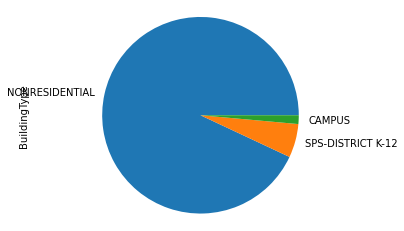

In [93]:
count = df[['OSEBuildingID', 'BuildingType']].drop_duplicates('OSEBuildingID')['BuildingType'].value_counts(normalize=True)
count.plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique

del count

Je peux déjà voir que le type bâtiment n'est pas uniformément représenté.

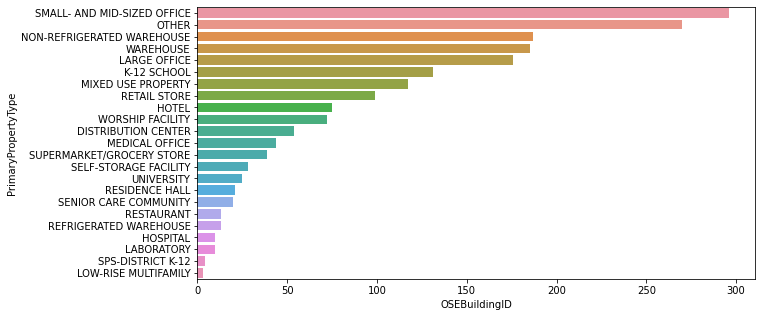

In [94]:
plt.figure(figsize=(10, 5))
count = df.groupby('PrimaryPropertyType', as_index = False)[['OSEBuildingID']].nunique().sort_values('OSEBuildingID',ascending = False)
sns.barplot(x = count.OSEBuildingID, y = count.PrimaryPropertyType)
plt.show();

del count

Le type de bâtiment principal de la propriété non plus.

In [95]:
def split_words(df, column = None):
  list_words = set()
  for word in df[column].str.split(', '):
    if isinstance(word, float):
      continue
    value = [re.sub(r'^\s', '', x) for x in word]
    list_words = set().union(value, list_words)
  return list(list_words)

list_use_type = split_words(df, 'ListOfAllPropertyUseTypes')
print("Nombre de type d'usages dans la base : {}".format(len(list_use_type)))
list_use_type.sort()
print(list_use_type)
del list_use_type

Nombre de type d'usages dans la base : 66
['ADULT EDUCATION', 'AUTOMOBILE DEALERSHIP', 'BANK BRANCH', 'BAR/NIGHTCLUB', 'COLLEGE/UNIVERSITY', 'CONVENIENCE STORE WITHOUT GAS STATION', 'COURTHOUSE', 'DATA CENTER', 'DISTRIBUTION CENTER', 'EDUCATION', 'ENCLOSED MALL', 'ENTERTAINMENT/PUBLIC ASSEMBLY', 'FAST FOOD RESTAURANT', 'FINANCIAL OFFICE', 'FIRE STATION', 'FITNESS CENTER/HEALTH CLUB/GYM', 'FOOD SALES', 'FOOD SERVICE', 'HOSPITAL', 'HOTEL', 'K-12 SCHOOL', 'LABORATORY', 'LIBRARY', 'LIFESTYLE CENTER', 'LODGING/RESIDENTIAL', 'MALL', 'MANUFACTURING/INDUSTRIAL PLANT', 'MEDICAL OFFICE', 'MOVIE THEATER', 'MULTIFAMILY HOUSING', 'MUSEUM', 'NON-REFRIGERATED WAREHOUSE', 'OFFICE', 'OTHER', 'OUTPATIENT REHABILITATION/PHYSICAL THERAPY', 'PARKING', 'PERFORMING ARTS', 'PERSONAL SERVICES', 'POLICE STATION', 'PRE-SCHOOL/DAYCARE', 'PRISON/INCARCERATION', 'PUBLIC SERVICES', 'RECREATION', 'REFRIGERATED WAREHOUSE', 'REPAIR SERVICES', 'RESIDENCE HALL/DORMITORY', 'RESIDENTIAL CARE FACILITY', 'RESTAURANT', 'RESTA

Après avoir regarder toutes ces variables catégorisant les propriétés en terme de type d'usage du bâtiment, je peux dire que les types de bâtiments ne sont pas uniformément répartis. C'est un point à prendre en compte pour l'analyse des corrélations des variables et surtout pour la 2ème phase qu'est la modélisation des données.

#### Code postal

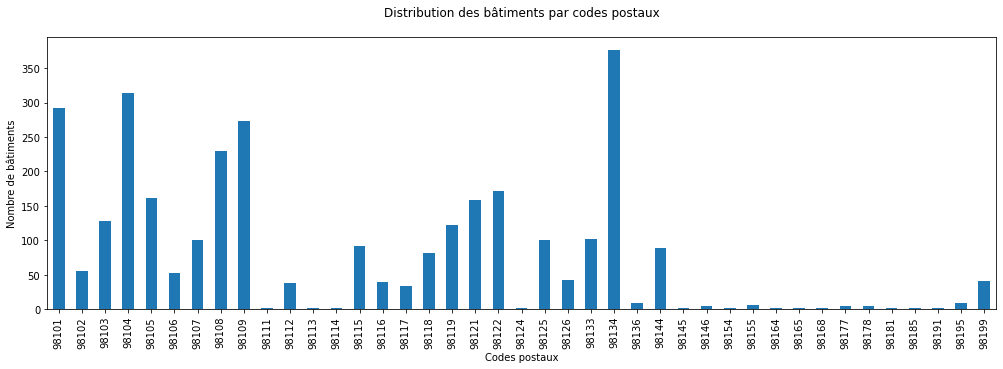

In [96]:
count = pd.DataFrame(df.groupby('ZipCode')['ZipCode'].count())
ax = count['ZipCode'].plot(kind='bar', figsize=(17, 5))
ax.set_xlabel("Codes postaux")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des bâtiments par codes postaux\n")
plt.show();

del count, ax

On peut voir que les codes postaux de 98101 à 98134 ont beaucoup plus de bâtiments que les autres.

### Variables numériques

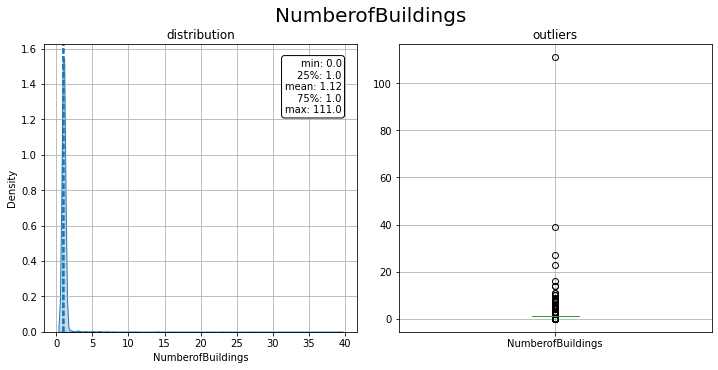

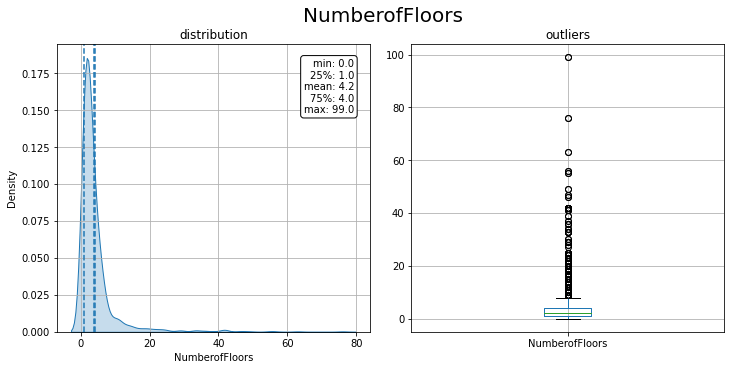

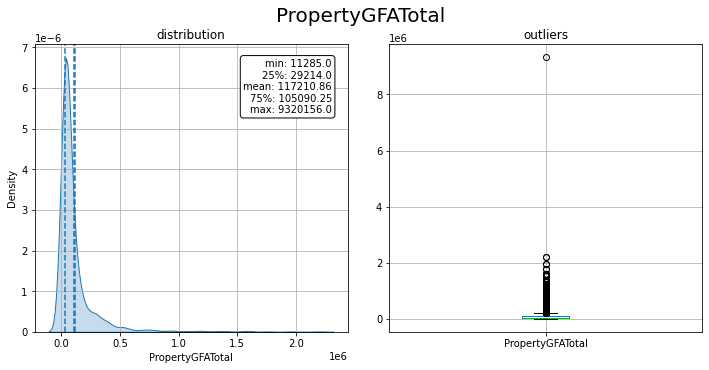

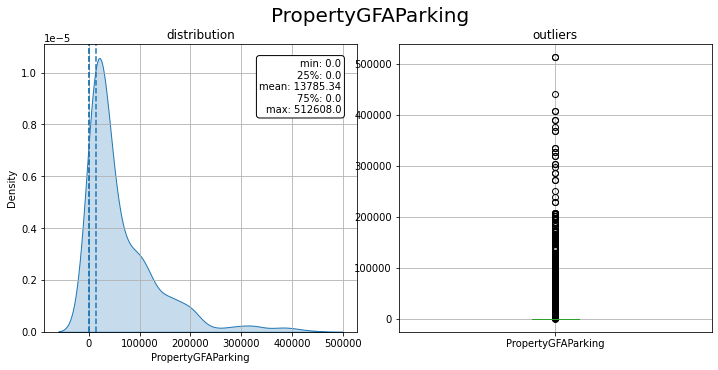

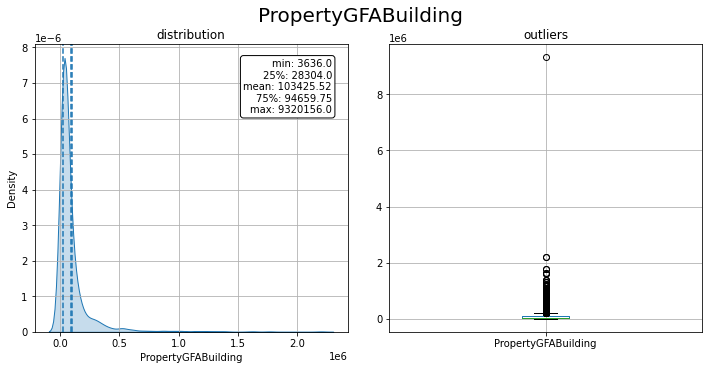

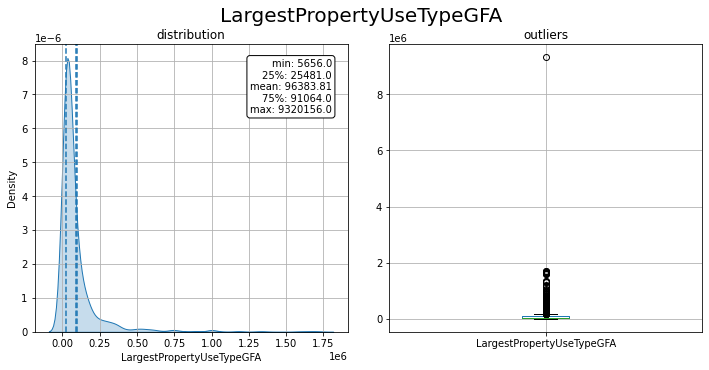

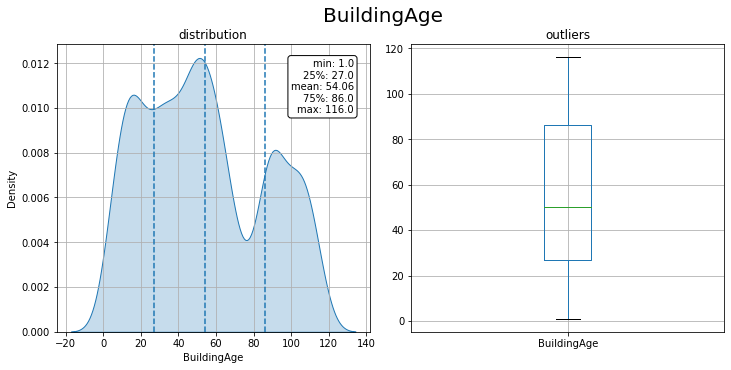

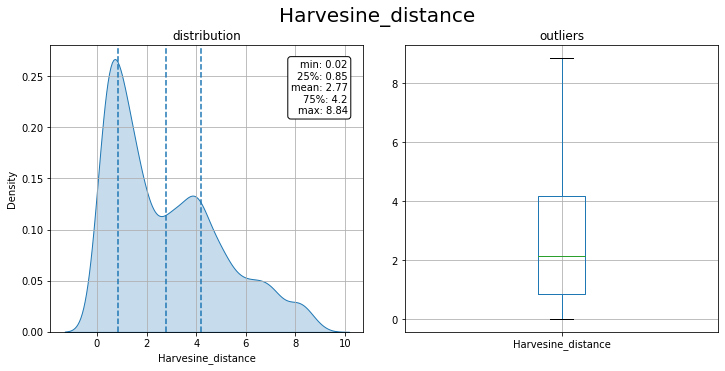

In [97]:
for col in listVarNum:
    x = col

    fig, ax = plt.subplots(nrows = 1, ncols = 2,  sharex = False, sharey = False, figsize=(10, 5))
    fig.suptitle(x, fontsize = 20)
    fig.tight_layout()
    
    ### distribution
    ax[0].title.set_text('distribution')
    variable = df[x].fillna(df[x].mean())
    breaks = np.quantile(variable, q = np.linspace(0, 1, 11))
    variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ]
    sns.kdeplot(variable, shade = True, ax = ax[0])
    des = df[x].describe()
    ax[0].axvline(des["25%"], ls = '--')
    ax[0].axvline(des["mean"], ls = '--')
    ax[0].axvline(des["75%"], ls = '--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

    ### boxplot 
    ax[1].title.set_text('outliers')
    df.boxplot(column = x, ax = ax[1])
    plt.show();

#### Année de construction

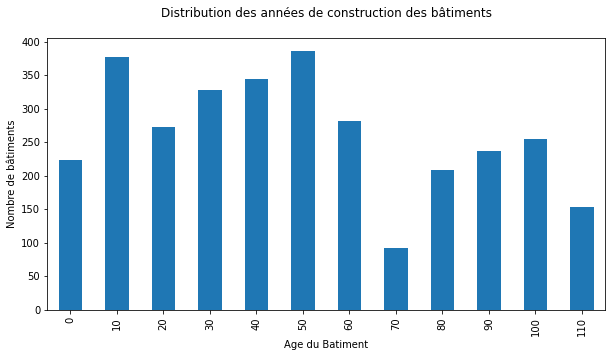

In [98]:
count = pd.DataFrame(df.groupby('BuildingAge')['BuildingAge'].count())
count['decade'] = count.index.astype(int) - (count.index.astype(int)%10)
count.groupby('decade')['BuildingAge'].sum()
ax = count.groupby('decade')['BuildingAge'].sum().plot(kind='bar', figsize=(10, 5))
ax.set_xlabel("Age du Batiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n")
plt.show();

#### Superficies des bâtiments

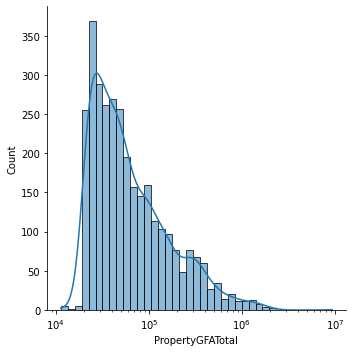

In [99]:
sns.displot(df['PropertyGFATotal'], kde=True, log_scale=True)
plt.show();

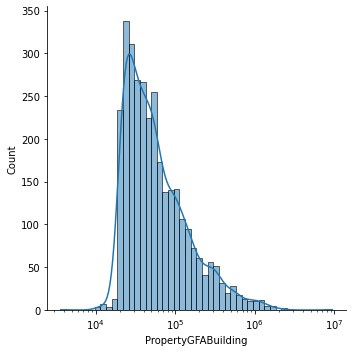

In [100]:
sns.displot(df['PropertyGFABuilding'], kde=True, log_scale=True)
plt.show();

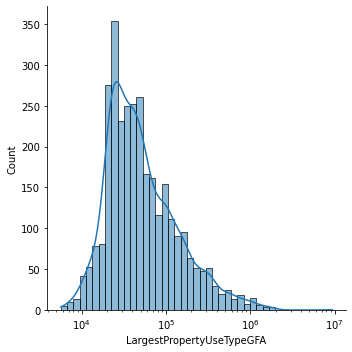

In [101]:
sns.displot(df['LargestPropertyUseTypeGFA'], kde=True, log_scale=True)
plt.show();

#### Nombre d'étages / de bâtiments

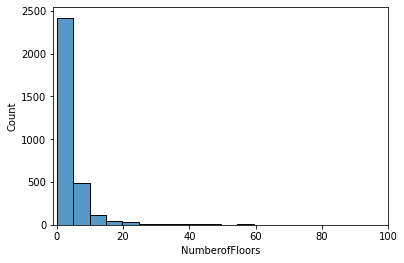

In [102]:
sns.histplot(df['NumberofFloors'], bins = 20)
plt.xlim(df['NumberofFloors'].min()-1,df['NumberofFloors'].max()+1)
plt.show();

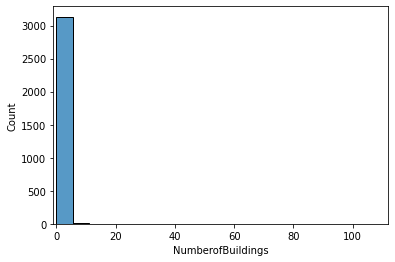

In [103]:
sns.histplot(df['NumberofBuildings'], bins = 20)
plt.xlim(df['NumberofBuildings'].min()-1,df['NumberofBuildings'].max()+1)
plt.show();

### Variables à estimer
#### SiteEnergyUse(kBtu) : Consommation d'énergie des bâtiments

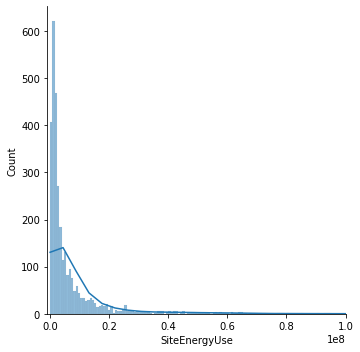

In [104]:
sns.displot(df['SiteEnergyUse'], kde=True)
plt.xlim(-1000000,100000000)
plt.show();

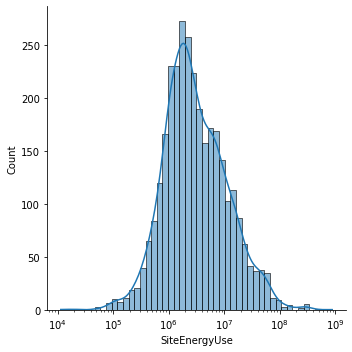

In [105]:
sns.displot(df['SiteEnergyUse'], kde=True, log_scale = True)
plt.show();

#### TotalGHGEmissions : Emissions de CO2 des bâtiments

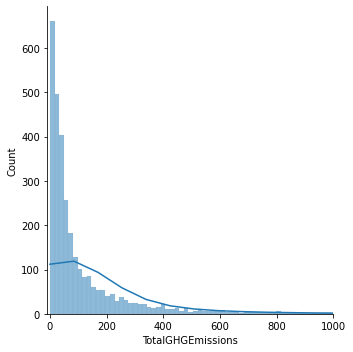

In [106]:
sns.displot(df['TotalGHGEmissions'], kde=True)
plt.xlim(-10,1000)
plt.show();

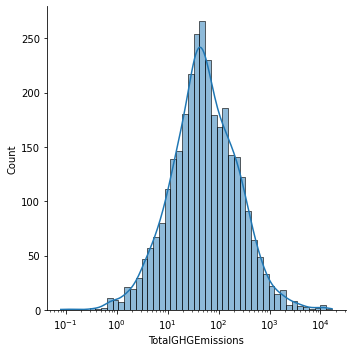

In [107]:
sns.displot(df['TotalGHGEmissions'], kde=True, log_scale = True)
plt.show();

Après avoir afficher les distributions des 2 variables à estimer, je peux voir qu'elles ne suivent pas une loi normale. En les passant au log, elles ressemblent plus à un loi normale ce qui faciliterait la mise en place du modèle. Je vais donc transformer les variables à estimer.

## Analyse bivariée

Certaines corrélations entre variables explicatives peuvent affaiblir les performances d’algorithme de Machine Learning (comme des régressions linéaires). Par conséquent, dans les 2 prochaines parties, je ne vais pas seulement regarder les corrélations entre les variables explicatives et les variables à estimer, mais je vais aussi regarder les corrélations entre les variables explicatives.

### Variables explicatives numériques

#### Corrélation entre les variables explicatives numériques et les variables à estimer

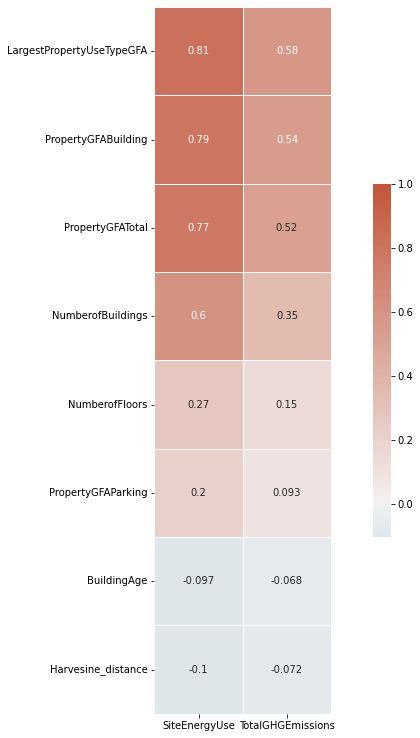

In [108]:
listVarCorr = listVarNum + listVarPred

# Compute the correlation matrix
corr = df[listVarCorr].corr()

# pour ne garder que la dernière ligne
listRow = listVarCorr.copy()
for x in listVarPred:
    listRow.remove(x)
corr = corr.loc[:,listVarPred].copy()
corr = corr.loc[listRow,:].copy()
corr = corr.sort_values(by = corr.columns.tolist()[0], ascending = False)
del listVarCorr, listRow

# je retiens les variables qui sont le plus corrélés avec les variables à estimer
corr['max'] = corr.max(axis = 1)
listVarExpNumCorr = corr.loc[(corr['max']>0.2)|(corr['max']<-0.2)].index.to_list()
corr = corr.drop(columns = 'max')

# Generate a mask for the upper triangle
mask = np.ones_like(corr, dtype=bool)
# np.triu() = Renvoie une copie d'un tableau avec les éléments sous la k- ième diagonale mis à zéro.
# np.ones_like() = Renvoie un tableau de 1 avec la même forme et le même type qu'un tableau donné.
# pour ne garder que la dernière ligne
mask[:, :] = False

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [109]:
listVarExpNumCorr

['LargestPropertyUseTypeGFA',
 'PropertyGFABuilding',
 'PropertyGFATotal',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking']

A première vue, les variables corrélées avec les variables à estimer sont celles relatant de la taille du bâtiment (variable nommé par GFA) et du nombre de bâtiment. 

En allant plus loin, il serait plus intéressant de choisir la variable de superficie du bâtiment principal (*LargestPropertyUseTypeGFA*) qui a une plus forte corrélation avec les 2 variables à estimer que pour les autres variables de superficie ==> 0.81 pour l'énergie et 0.57 pour les émissions de CO2. 

#### Corrélation des variables entre elles

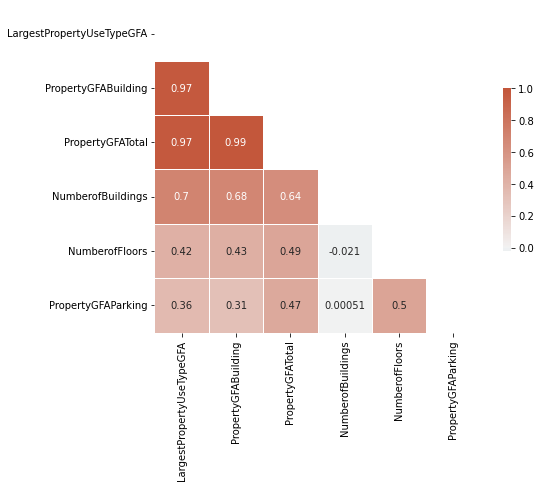

In [110]:
# Compute the correlation matrix
corr = df[listVarExpNumCorr].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# np.triu() = Renvoie une copie d'un tableau avec les éléments sous la k- ième diagonale mis à zéro.
# np.ones_like() = Renvoie un tableau de 1 avec la même forme et le même type qu'un tableau donné.
# pour ne garder que la dernière ligne

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Les variables explicatives numériques sont très corrélées entre elle. 

### Variables explicatives catégorielles

#### Corrélations entre les variables explicatives catégorielles et les variables à estimer

Pour chaque couple de variables, je testes l'hypothèse d'indépendance et si l'hypothèse d'indépendance est rejeté, je calcule le V de Cramer pour connaitre le niveau de corrélation entre ses variables.

C:\Users\bland\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\bland\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


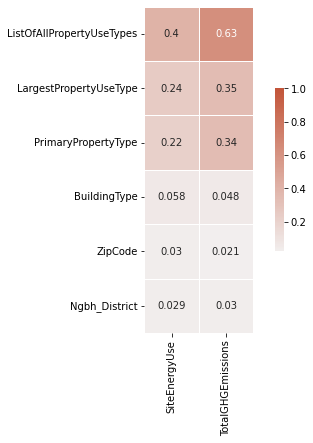

,Nb_modalite
Address,2461
ListOfAllPropertyUseTypes,387
LargestPropertyUseType,55
PrimaryPropertyType,23
BuildingType,3
ZipCode,41
Ngbh_District,27


In [111]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import levene, shapiro, kruskal, mannwhitneyu

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

df_corr = pd.DataFrame(columns = ['var'] + listVarPred)

for x in listVarPred:
    for y in listVarCat:
        w, pvalueNorm = shapiro(df[x])
        if pvalueNorm > 0.05: # distribution normale
            del w, pvalueNorm
            stat, p = levene(*[group[x].values for name, group in iris.groupby(y)])
            if p > 0.05: # variance égale
                test = 'ANOVA' # ANOVA
            else: # pas de variance égale
                test = 'NON' # test non-paramétrique
            del stat, p
        else: # pas distribution normale
            test = 'NON' # test non-paramétrique
        if test == 'ANOVA': # test ANOVA
            strMod = x + ' ~ C(' + y + ')'
            model = ols(strMod, data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            if anova_table[0,-1] < 0.05: # possible corrélation
                valEtaSq = eta_squared(df.loc[~df[y].isna(),y],df.loc[~df[y].isna(),x])
                if len(df_corr[df_corr['var'] == y]) == 0:
                    dictRow = {'var' : y , x : valEtaSq}
                    for col in df_corr.columns:
                        if col not in ['var', x]:
                            dictRow[col] = np.nan
                    df_corr = pd.concat([df_corr,pd.DataFrame([dictRow])], ignore_index=False).reset_index(drop = True)
                else:
                    df_corr.iloc[df_corr['var'] == y, x] = valEtaSq
            del strMod, model, anova_table
        else: # test non paramétrique
            if df[y].nunique() > 2: # test de Kruskal-Wallis
                # Faire le test
                kstat, pval = kruskal(df[x], df[y].astype("category").cat.codes)
                n = df[y].shape[0]
                # Récupérer la p-value
                if pval < 0.05: # possible corrélation
                    valEtaSq = eta_squared(df.loc[~df[y].isna(),y],df.loc[~df[y].isna(),x])
                    if len(df_corr[df_corr['var'] == y]) == 0:
                        dictRow = {'var' : y , x : valEtaSq}
                        for col in df_corr.columns:
                            if col not in ['var', x]:
                                dictRow[col] = np.nan
                        df_corr = pd.concat([df_corr,pd.DataFrame([dictRow])], ignore_index=False).reset_index(drop = True)
                    else:
                        df_corr.loc[df_corr['var'] == y, x] = valEtaSq
                del kstat
            else: # test U de Mann-Whitney
                a = df[y].unique()[0]
                b = df[y].unique()[1]
                # perform two-sided test. You can use 'greater' or 'less' for one-sided test
                mstat, pval = mannwhitneyu(x=df[df[y] == a][x], y=df[df[y] == b][x], alternative = 'two-sided')
                # Récupérer la p-value
                if pval < 0.05: # possible corrélation
                    valEtaSq = eta_squared(df.loc[~df[y].isna(),y],df.loc[~df[y].isna(),x])
                    if len(df_corr[df_corr['var'] == y]) == 0:
                        dictRow = {'var' : y , x : valEtaSq}
                        for col in df_corr.columns:
                            if col not in ['var', x]:
                                dictRow[col] = np.nan
                        df_corr = pd.concat([df_corr,pd.DataFrame([dictRow])], ignore_index=False).reset_index(drop = True)
                    else:
                        df_corr.iloc[df_corr['var'] == y, x] = valEtaSq
                del a,b, mstat
            del test, pval

for row in df_corr.index:
    value = df[df_corr.loc[row,'var']].nunique()
    df_corr.loc[row,'Nb_modalite'] = value
df_corr['Nb_modalite'] = df_corr['Nb_modalite'].astype(int)
df_corr = df_corr.set_index('var')
df_corr.index.name = None

# je retiens les variables qui sont le plus corrélés avec les variables à estimer
df_corr['max'] = df_corr[['SiteEnergyUse','TotalGHGEmissions']].max(axis = 1)
listVarExpCatCorr = df_corr.loc[(df_corr['Nb_modalite']<(df.shape[0]/2))
                                &((df_corr['max']>0.2)|(df_corr['max']<-0.2))
                               ].sort_values('max', ascending = False).index.to_list()
df_corr.drop(columns = 'max', inplace = True)

############ HEATMAP #############

corr = df_corr[df_corr['Nb_modalite']<(df.shape[0]/2)][['SiteEnergyUse','TotalGHGEmissions']].sort_values('SiteEnergyUse', ascending = False).copy()
corr['SiteEnergyUse'] = corr['SiteEnergyUse'].astype(float)
corr['TotalGHGEmissions'] = corr['TotalGHGEmissions'].astype(float)
# Generate a mask for the upper triangle
mask = np.ones_like(corr, dtype=bool)
# np.triu() = Renvoie une copie d'un tableau avec les éléments sous la k- ième diagonale mis à zéro.
# np.ones_like() = Renvoie un tableau de 1 avec la même forme et le même type qu'un tableau donné.
# pour ne garder que la dernière ligne
mask[:, :] = False

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show();
    
df_corr.sort_values('SiteEnergyUse', ascending = False)[['Nb_modalite']]

In [112]:
listVarExpCatCorr

['ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'PrimaryPropertyType']

Au vue des mesures de taille d'effet de corrélation du tableau ci-dessus, les variables fortement corrélées avec les variables à estimer sont : 
- ListOfAllPropertyUseTypes
- LargestPropertyUseType
- PrimaryPropertyType

Seulement, *ListOfAllPropertyUseTypes* possèdent plusieurs types par cellule. Cela pourrait compliquer la modélisation. 

Je vais maintenant regarder les corrélations entre ses variables

#### Corrélations des variables entre elles

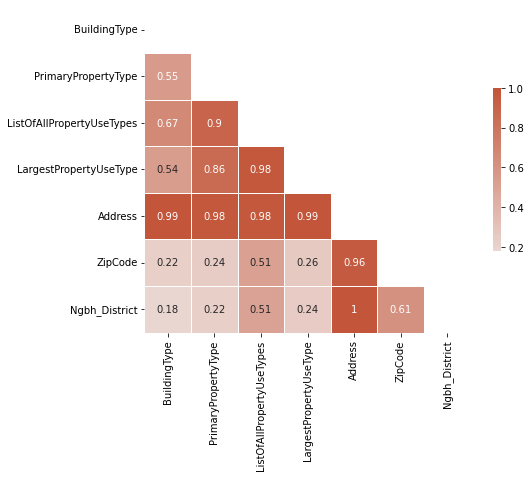

In [113]:
del df_corr
df_corr = pd.DataFrame(columns = listVarCat, dtype = float, index = listVarCat)

for row in df_corr.index:
    for col in df_corr.columns:
        resultat_test = chi2_contingency(pd.crosstab(df[row], df[col]))
        if resultat_test[1] < 0.05:
            n = sum(pd.crosstab(df[row], df[col]).sum())
            valVCramer = np.sqrt(resultat_test[0] / (n*(min(pd.crosstab(df[row], df[col]).shape)-1)))
            df_corr.loc[row, col] = valVCramer

############ HEATMAP #############

corr = df_corr.copy()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# np.triu() = Renvoie une copie d'un tableau avec les éléments sous la k- ième diagonale mis à zéro.
# np.ones_like() = Renvoie un tableau de 1 avec la même forme et le même type qu'un tableau donné.
# pour ne garder que la dernière ligne

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Les variables *ListOfAllPropertyUseTypes*, *PrimaryPropertyType* et *LargestPropertyUseType* sont bien corrélées entre elles. Je vais donc commencer ma modélisation avec la variable *LargestPropertyUseType* uniquement. Si jamais l'évaluation du modèle n'est pas satisfaisant, j'essaierai avec *PrimaryPropertyType*.

### Variables explicatives combinées

Je vais aussi regarder s'il y a des tendances en faisant des combinaisons de variables.

In [114]:
listVarExpCatCorr.remove('ListOfAllPropertyUseTypes')

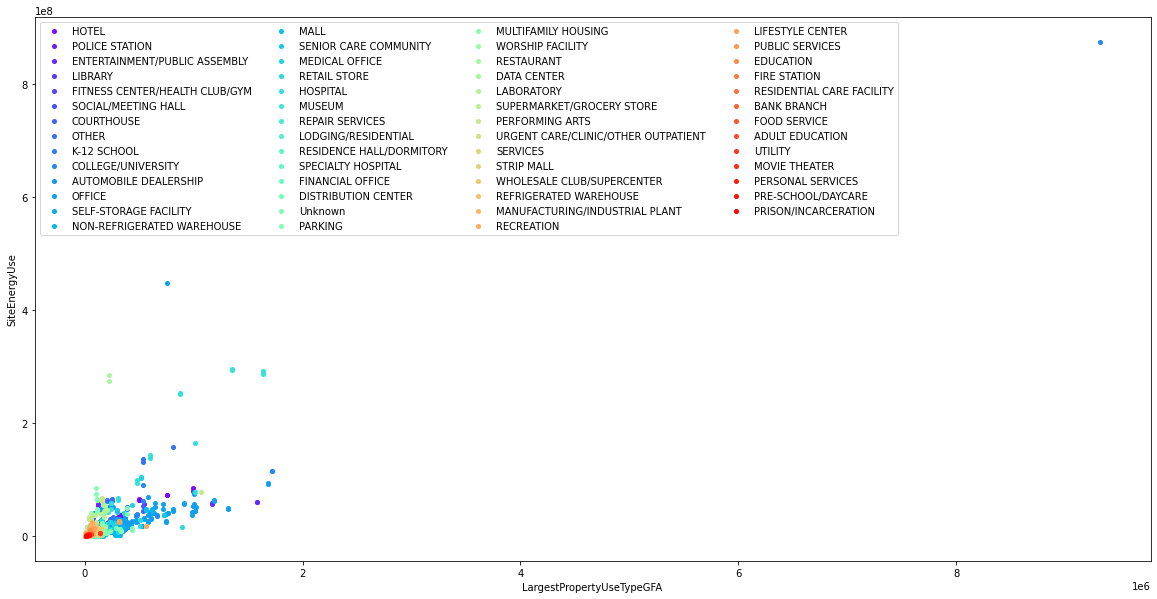

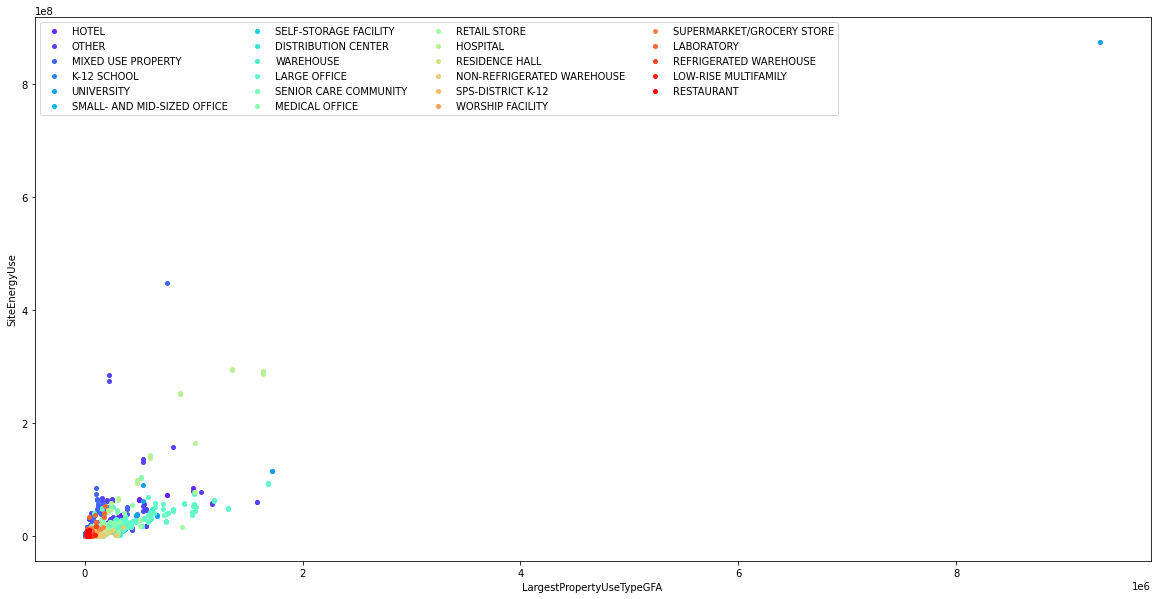

In [115]:
for var in listVarExpCatCorr:
    colors = cm.rainbow(np.linspace(0, 1, df[var].nunique()+1))
    i = 1
    plt.figure(figsize=(20, 10))
    for x in df[var].unique():
        df_temp = df[df[var] == x]
        # On affiche le nuage de points dont on dispose
        plt.plot(df_temp[listVarExpNumCorr[0]], df_temp[listVarPred[0]], 'o', markersize=4, color=colors[i])
        i = i + 1
    plt.xlabel(listVarExpNumCorr[0])
    plt.ylabel(listVarPred[0])
    plt.legend(df[var].unique(), loc='best', ncol = 4)
    plt.show();

Je peux voir que les types de bâtiments ont des ordres de grandeurs différents. La combinaison variable numérique et variable catégorielle pourrait être intéressante pour la modélisation.

## Analyse multivariée

Les variables explicatives étant fortement corrélées entre elle, je vais faire une ACP, analyse en composante principale pour voir si je ne peux pas synthétiser toutes ces variables en un ou deux axes d'inertie.

In [116]:
# Je ne définis que les variables avec une forte corrélation avec les variables à estimer pour l'ACP
data_pca = df[listVarExpNumCorr].copy()
data_pca.isna().sum()

LargestPropertyUseTypeGFA    0
PropertyGFABuilding          0
PropertyGFATotal             0
NumberofBuildings            0
NumberofFloors               0
PropertyGFAParking           0
dtype: int64

In [117]:
n_comp = data_pca.shape[1]
n_comp

6

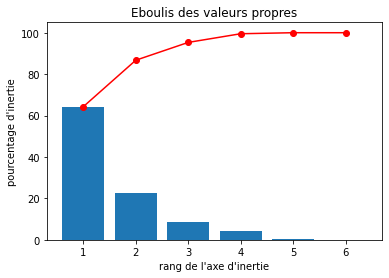

In [118]:
X = data_pca.values
names = data_pca.index # ou data_pca.index pour avoir les intitulés servant pour les afficher sur le nuage des individus
features = data_pca.columns # sert pour afficher les labels des variables sur le cercle des corrélations

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled) # ou X dans le cas d'un centrage uniquement

display_scree_plot(pca)

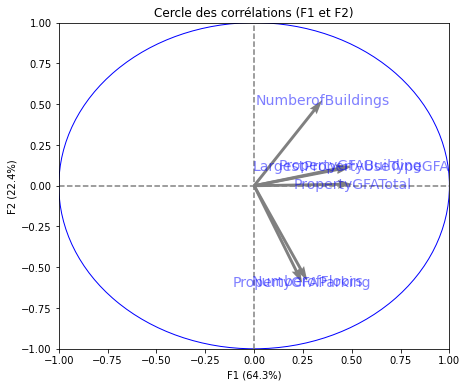

In [119]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

Le premier axe d'inertie synthétise assez les variables représentant la taille du bâtiment. Je vais donc la garder de côté pour la partie modélisation.

In [120]:
df_pca = pd.DataFrame(pca.fit_transform(X_scaled), index = df.index, columns = ['F'+str(i+1) for i in range(n_comp)])
df = df.merge(df_pca['F1'], left_index = True, right_index = True, how = 'left')
df = df.merge(df_pca['F2'], left_index = True, right_index = True, how = 'left')
df.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse,TotalGHGEmissions,Address,ZipCode,BuildingAge,Harvesine_distance,Ngbh_District,F1,F2
241,1,NONRESIDENTIAL,HOTEL,MAYFLOWER PARK HOTEL,659000030,1,12,88434,0,88434,HOTEL,HOTEL,88434,65.00,6981428.00,249.43,405 OLIVE WAY,98101,88,0.50,DOWNTOWN_7,0.12,-0.54
3340,1,NONRESIDENTIAL,HOTEL,MAYFLOWER PARK HOTEL,659000030,1,12,88434,0,88434,HOTEL,HOTEL,88434,60.00,7226362.50,249.98,405 OLIVE WAY,98101,89,0.50,DOWNTOWN_7,0.12,-0.54
361,2,NONRESIDENTIAL,HOTEL,PARAMOUNT HOTEL,659000220,1,11,103566,15064,88502,"HOTEL, PARKING, RESTAURANT",HOTEL,83880,51.00,8354235.00,263.51,724 PINE ST,98101,19,0.48,DOWNTOWN_7,0.18,-0.65
3341,2,NONRESIDENTIAL,HOTEL,PARAMOUNT HOTEL,659000220,1,11,103566,15064,88502,"HOTEL, PARKING, RESTAURANT",HOTEL,83880,61.00,8387933.00,295.86,724 PINE STREET,98101,20,0.49,DOWNTOWN_7,0.18,-0.65
509,3,NONRESIDENTIAL,HOTEL,WESTIN HOTEL,659000475,1,41,961990,0,961990,"HOTEL, PARKING, SWIMMING POOL",HOTEL,757243,18.00,73130656.00,2061.48,1900 5TH AVE,98101,46,0.56,DOWNTOWN_7,6.27,-2.26


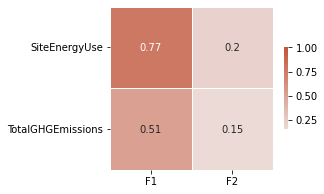

In [121]:
corr = df[['F1', 'F2','SiteEnergyUse','TotalGHGEmissions']].corr()
corr = pd.DataFrame(corr.loc[:,['F1','F2']], columns = ['F1','F2'])
corr = corr.loc[['SiteEnergyUse','TotalGHGEmissions'],:]

# Generate a mask for the upper triangle
mask = np.ones_like(corr, dtype=bool)
# np.triu() = Renvoie une copie d'un tableau avec les éléments sous la k- ième diagonale mis à zéro.
# np.ones_like() = Renvoie un tableau de 1 avec la même forme et le même type qu'un tableau donné.
# pour ne garder que la dernière ligne
mask[:, :] = False

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4, 3))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

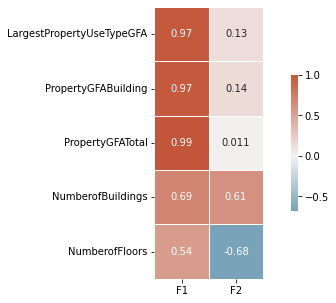

In [122]:
listVarExpNumCorr.append('F1')
listVarExpNumCorr.append('F2')
corr = df[listVarExpNumCorr].corr()
corr = corr.iloc[:5,-2:]

# Generate a mask for the upper triangle
mask = np.ones_like(corr, dtype=bool)
# np.triu() = Renvoie une copie d'un tableau avec les éléments sous la k- ième diagonale mis à zéro.
# np.ones_like() = Renvoie un tableau de 1 avec la même forme et le même type qu'un tableau donné.
# pour ne garder que la dernière ligne
mask[:,:] = False

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Malgré l'illisibilité des étiquettes sur le graphiques du cercle des corrélations, je peux maintenant voir que la variable F1, synthétise toutes les variables explicatives numériques (surtout celles des superficie), alors que la variable F2, synthétise les variables de nombre de bâtiment et d'étage.

In [123]:
df[['F1','F2']].corr()

,F1,F2
F1,1.00,0.00
F2,0.00,1.00


Je peux aussi voir, qu'elles ne sont absolument pas corrélés entre elles.

In [124]:
w, pvalueNorm = shapiro(df['F2'])
print('Test de normalité :',pvalueNorm)

Test de normalité : 0.0


In [125]:
for x in ['F1','F2']:
    for y in listVarExpCatCorr:
        kstat, pval = kruskal(df[x], df[y].astype("category").cat.codes)
        n = df[y].shape[0]
        # Récupérer la p-value
        if pval < 0.05: # possible corrélation
            valEtaSq = eta_squared(df.loc[~df[y].isna(),y],df.loc[~df[y].isna(),x])
            print('Corrélation entre', x, 'et', y, ':', round(valEtaSq,4))
        del kstat, pval

Corrélation entre F1 et LargestPropertyUseType : 0.0984
Corrélation entre F1 et PrimaryPropertyType : 0.1884
Corrélation entre F2 et LargestPropertyUseType : 0.13
Corrélation entre F2 et PrimaryPropertyType : 0.2086


Elles sont aussi et très peu corrélées avec les variables catégorielles.

# Conclusions

Pour conclure, les variables à prendre en compte pour le modèle sont :

In [126]:
listVarExpNumCorr

['LargestPropertyUseTypeGFA',
 'PropertyGFABuilding',
 'PropertyGFATotal',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'F1',
 'F2']

In [127]:
listVarExpCatCorr

['LargestPropertyUseType', 'PrimaryPropertyType']

Mais en approfondissant, j'ai remarqué que ces variables sont fortement corrélées entre elles. J'ai créé la variable F1, variable synthétisant les variables numériques explicatives, pour essayer de palier à ces corrélations.

De plus, j'ai remarqué que les variables ont aussi des tendances générales avec les autres variables. Ces dernières pourraient donc venir compléter et améliorer les performances des modèles.

# Exportations du jeu de données

Avant d'exporter le jeu de données, je supprime toutes les variables non explicatives.

In [128]:
df.to_csv('E:/Formations/6. Diplôme Data Scientist/Projet/Projet-4/Building_Energy_Benchmarking_cleaning.csv', index = False)